## Setup

In [433]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import warnings
import seaborn as sns
import os
import re
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json

from google import genai
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tslearn.clustering import TimeSeriesKMeans, KShape
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pyts.metrics import dtw
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score  # Or other relevant metric
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Suppress specific warnings (in this case, FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(42)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Analysis

In [3]:
online_retail_df = pd.read_json('../dataset/online_retail_data/online_retail.json')
online_retail_df

Date                  FuzzedDescription  UnitsSold  \
0     2009-12-01   12 pencils small tube red spotty         45   
1     2009-12-01          12 pencils tall tube posy         69   
2     2009-12-01      12 pencils tall tube woodland          4   
3     2009-12-01           3 stripey mice feltcraft          9   
4     2009-12-01             6 ribbons rustic charm         27   
...          ...                                ...        ...   
48125 2010-12-09  wooden picture frame white finish         22   
48126 2010-12-09        wooden school colouring set         13   
48127 2010-12-09             woodland charlotte bag          5   
48128 2010-12-09  world war 2 gliders asstd designs         52   
48129 2010-12-09        zinc metal heart decoration          3   

       PricePerUnitPounds  RevenuePounds  
0                    0.76          34.20  
1                    1.08          74.52  
2                    1.27           5.08  
3                    2.54          22.86  
4                    2.67          72.09  
...                   ...            ...  
48125                2.55          56.10  
48126                2.50          32.50  
48127                1.25           6.25  
48128                0.36          18.72  
48129                1.25           3.75  

[48130 rows x 5 columns]

In [14]:
pivoted_df = online_retail_df.pivot(index='Date', columns='FuzzedDescription', values='UnitsSold')
pivoted_df = pivoted_df.fillna(0)
pivoted_df

FuzzedDescription  12 pencils small tube red spotty  \
Date                                                  
2009-12-01                                     45.0   
2009-12-02                                     87.0   
2009-12-03                                     34.0   
2009-12-04                                     84.0   
2009-12-05                                      0.0   
...                                             ...   
2010-12-05                                    151.0   
2010-12-06                                    135.0   
2010-12-07                                     20.0   
2010-12-08                                     75.0   
2010-12-09                                     35.0   

FuzzedDescription  12 pencils tall tube posy  12 pencils tall tube woodland  \
Date                                                                          
2009-12-01                              69.0                            4.0   
2009-12-02                              87.0                           21.0   
2009-12-03                             116.0                           13.0   
2009-12-04                             160.0                           25.0   
2009-12-05                              24.0                            0.0   
...                                      ...                            ...   
2010-12-05                               6.0                           15.0   
2010-12-06                               4.0                           17.0   
2010-12-07                              15.0                            9.0   
2010-12-08                               0.0                           23.0   
2010-12-09                               2.0                           43.0   

FuzzedDescription  3 stripey mice feltcraft  6 ribbons rustic charm  \
Date                                                                  
2009-12-01                              9.0                    27.0   
2009-12-02                             19.0                     7.0   
2009-12-03                            101.0                     3.0   
2009-12-04                              7.0                     2.0   
2009-12-05                              0.0                     0.0   
...                                     ...                     ...   
2010-12-05                              4.0                    49.0   
2010-12-06                             36.0                    38.0   
2010-12-07                              9.0                    37.0   
2010-12-08                             14.0                    16.0   
2010-12-09                             31.0                    20.0   

FuzzedDescription  60 teatime fairy cake cases  \
Date                                             
2009-12-01                               173.0   
2009-12-02                               159.0   
2009-12-03                               201.0   
2009-12-04                                99.0   
2009-12-05                                 0.0   
...                                        ...   
2010-12-05                                 9.0   
2010-12-06                                57.0   
2010-12-07                                30.0   
2010-12-08                                77.0   
2010-12-09                                61.0   

FuzzedDescription  72 sweetheart fairy cake cases  \
Date                                                
2009-12-01                                   50.0   
2009-12-02                                  229.0   
2009-12-03                                   83.0   
2009-12-04                                    3.0   
2009-12-05                                    0.0   
...                                           ...   
2010-12-05                                   19.0   
2010-12-06                                    1.0   
2010-12-07                                   28.0   
2010-12-08                                   82.0   
2010-12-09                                   

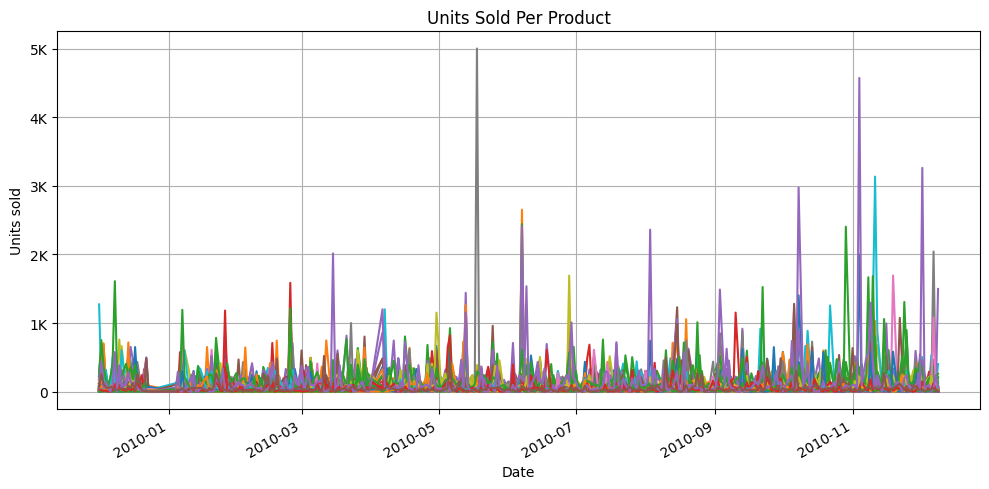

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

pivoted_df.plot(ax=ax)

ax.set_title('Units Sold Per Product')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
ax.legend().remove()
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Gemini

In [66]:
GEMINI_API_KEY = ''
gemini_client = genai.Client(api_key=GEMINI_API_KEY)

In [77]:
def get_gemini_description(client, product_description, sales_series) -> str:
    sales_data = ','.join(f'{date.strftime("%Y-%m-%d")}: {sales}' for date, sales in sales_series.sort_index().items())
    prompt = f"""\
    Describe the daily sales pattern of `{product_description}` over the given period.
    Please highlight significant increases, decreases, seasonality, or unusual events.
    Please just include the comprehensive description whose embedding I can later use
    to cluster products with similar patterns.
    The daily sales data is: {sales_data}
    """
    response = client.models.generate_content(
        model="gemini-2.0-flash-lite",
        contents=[prompt]
    )
    return response.text

In [79]:
gemini_descriptions = dict()
for product_description in tqdm(pivoted_df.columns):
    gemini_descriptions[product_description] = get_gemini_description(
        gemini_client,
        product_description,
        pivoted_df[product_description]
    )

100%|█████████████████████████████████████████| 196/196 [14:58<00:00,  4.58s/it]


In [81]:
GEMINI_DESCRIPTIONS_SAVE_DIR = '../dataset/gemini_product_descriptions'
os.makedirs(GEMINI_DESCRIPTIONS_SAVE_DIR, exist_ok=True)

with open(os.path.join(GEMINI_DESCRIPTIONS_SAVE_DIR, 'gemini_product_descriptions.json'), 'w') as file:
    json.dump(gemini_descriptions, file, indent=4)

In [88]:
gemini_descriptions_list = [
    (product_description, sales_description)
    for product_description, sales_description in gemini_descriptions.items()
]

product_descriptions, sales_descriptions = zip(*gemini_descriptions_list)
product_descriptions = list(product_descriptions)
sales_descriptions = list(sales_descriptions)

In [94]:
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# Normalizing makes the maximizing the cosine similarity the
# same as minimizing the Euclidean distance.
embeddings = model.encode(sales_descriptions, normalize_embeddings=True)
print(embeddings.shape)

(196, 768)


100%|███████████████████████████████████████████| 39/39 [00:03<00:00, 11.14it/s]


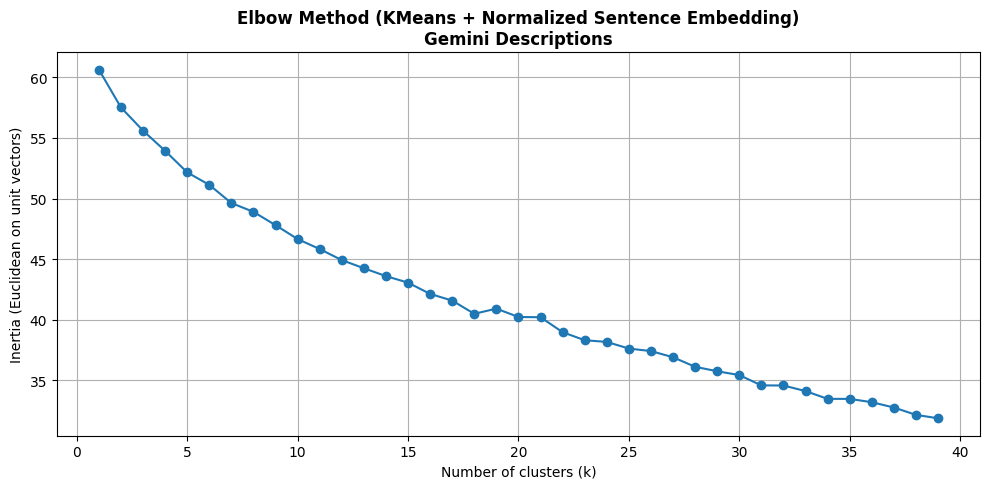

In [114]:
k_values = list(range(1, 40))
inertias = list()

for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(k_values, inertias, marker='o')

ax.set_title('Elbow Method (KMeans + Normalized Sentence Embedding)\nGemini Descriptions', fontweight='bold')
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Inertia (Euclidean on unit vectors)')
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [131]:
k = 10
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(embeddings)

gemini_kmeans_cluster_labels = kmeans.labels_

gemini_kmeans_clusters = [list() for label in range(k)]
for product, label in zip(product_descriptions, gemini_kmeans_cluster_labels):
    gemini_kmeans_clusters[label].append(product)

gemini_kmeans_clusters

[['box of 24 cocktail parasols',
  'ceramic cake design spotted mug',
  'gin tonic diet metal sign',
  'hot water bottle tea and sympathy',
  'i can only please one person mug',
  'large heart measuring spoons',
  'large popcorn holder',
  'pink doughnut trinket pot',
  'potting shed tea mug',
  'retro spot large milk jug',
  'retro spot small milk jug',
  'retro spot traditional teapot',
  'scottie dog hot water bottle',
  'set5 red spotty lid glass bowls',
  'small glass heart trinket pot',
  'small popcorn holder'],
 ['childs apron spaceboy design',
  'door mat 3 smiley cats',
  'door mat fancy font home sweet home',
  'door mat new england',
  'door mat red spot',
  'door mat spotty home sweet home',
  'door mat union flag',
  'doormat hearts',
  'doorstop retrospot heart',
  'love building block word',
  'memo board cottage design',
  'memo board retrospot design',
  'toy tidy spaceboy'],
 ['12 pencils tall tube woodland',
  '3 stripey mice feltcraft',
  '6 ribbons rustic charm',


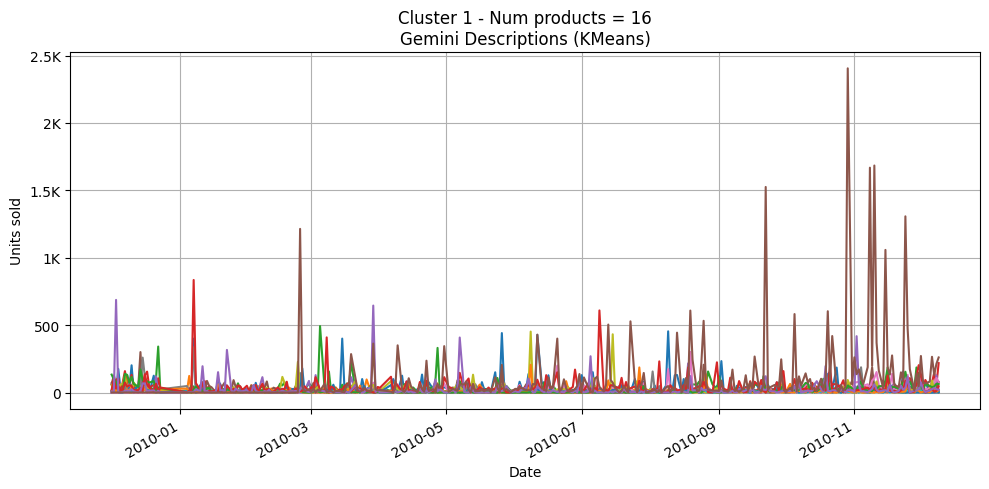

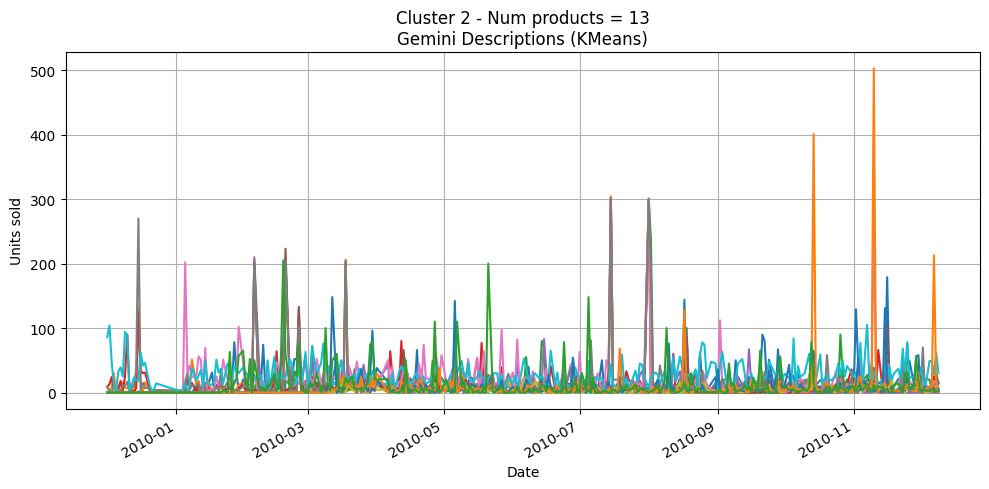

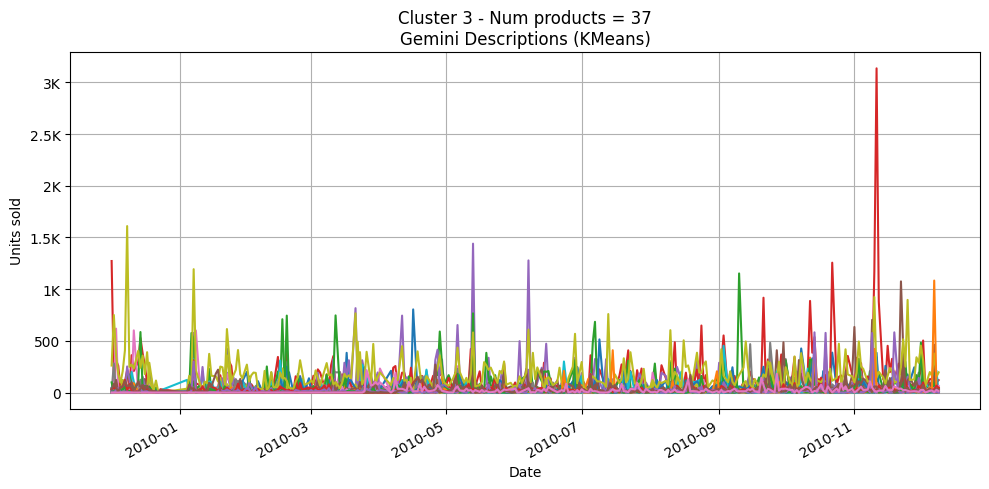

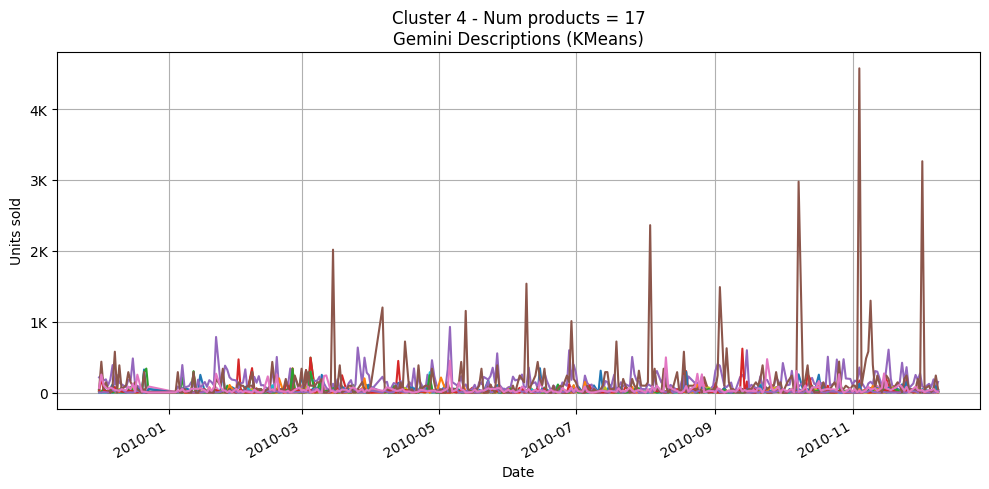

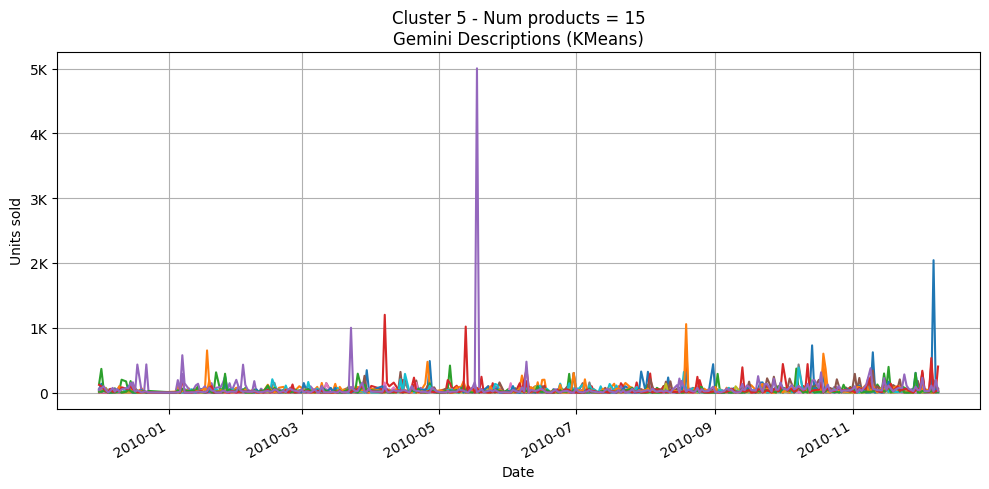

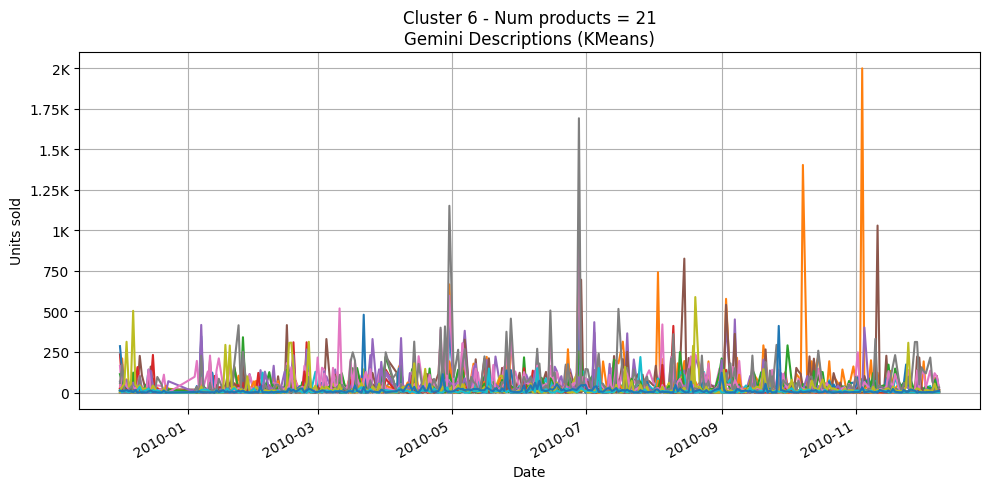

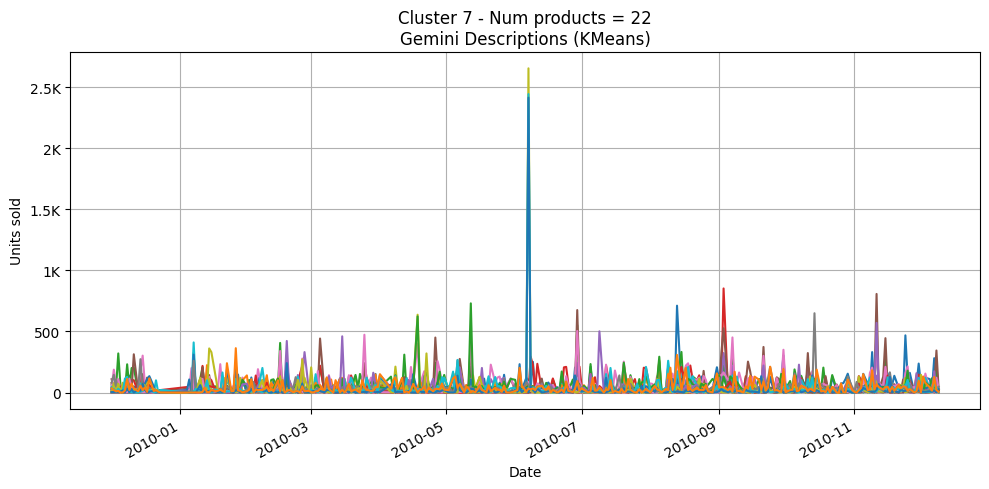

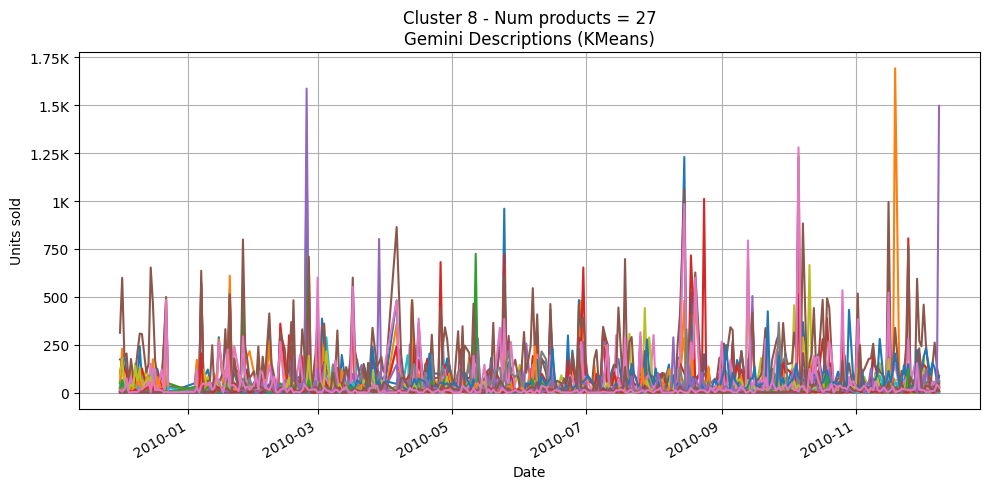

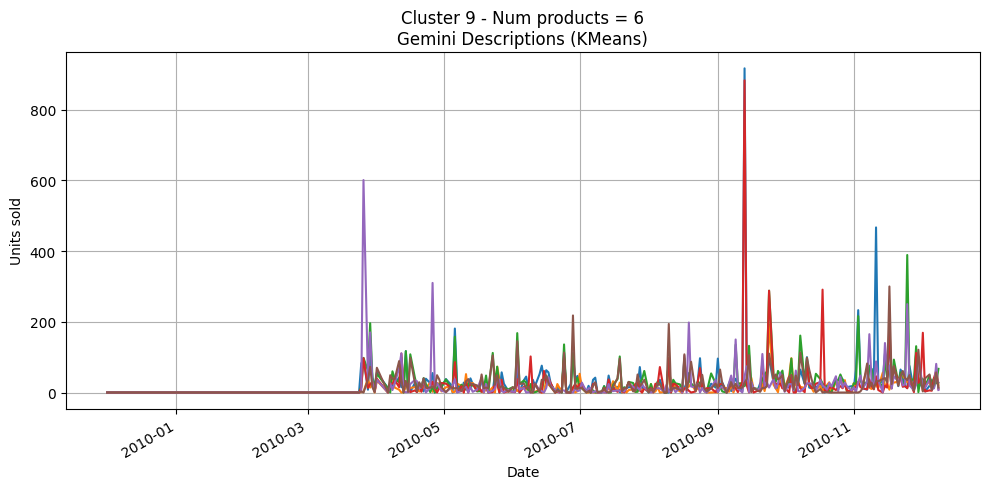

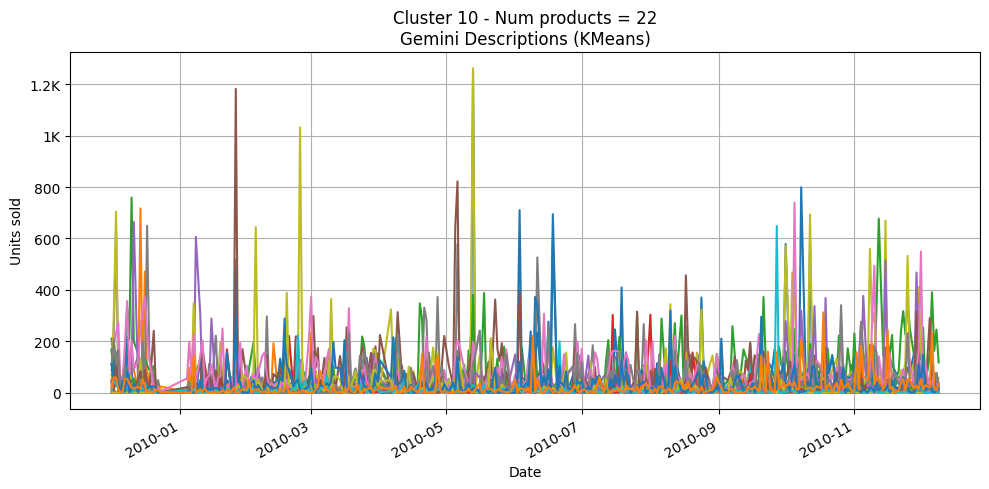

In [137]:
for i, cluster in enumerate(gemini_kmeans_clusters, start=1):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    num_products = len(cluster)
    pivoted_df[cluster].plot(ax=ax)
    ax.set_title(f'Cluster {i} - Num products = {num_products}\nGemini Descriptions (KMeans)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid(True, which='both')
    make_axes_human_readable(ax)
    ax.legend().remove()
    plt.tight_layout()
    plt.show()

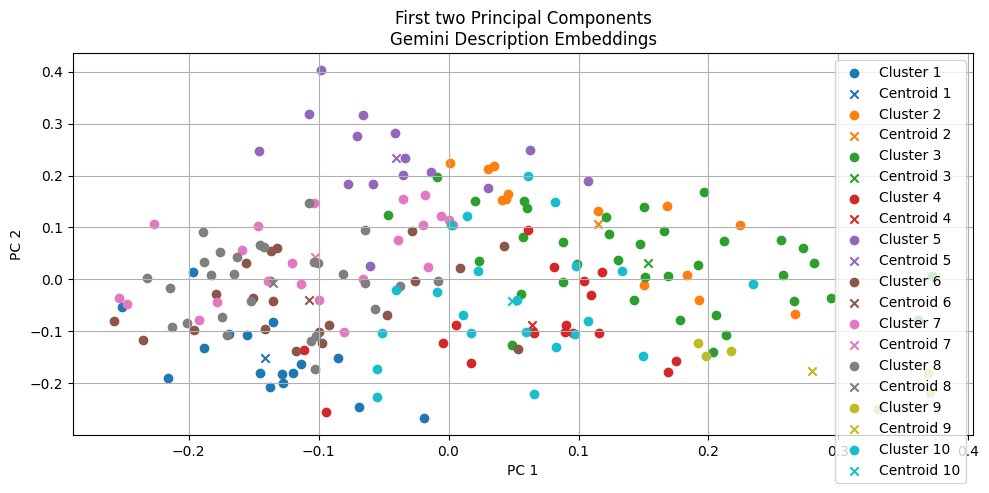

In [158]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
centroids = pca.transform(kmeans.cluster_centers_)

gemini_kmeans_cluster_reduced_embeddings = [list() for i in range(k)]
for e, label in zip(reduced_embeddings, gemini_kmeans_cluster_labels):
    gemini_kmeans_cluster_reduced_embeddings[label].append(e)

for i, l in enumerate(gemini_kmeans_cluster_reduced_embeddings):
    gemini_kmeans_cluster_reduced_embeddings[i] = np.array(l)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
for i, (e, c) in enumerate(zip(gemini_kmeans_cluster_reduced_embeddings, centroids), start=1):
    s = ax.scatter(e[:,0], e[:,1], label=f'Cluster {i}')
    ax.scatter(c[0], c[1], color=s._facecolors[0], marker='x', label=f'Centroid {i}')


ax.set_title('First two Principal Components\nGemini Description Embeddings')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

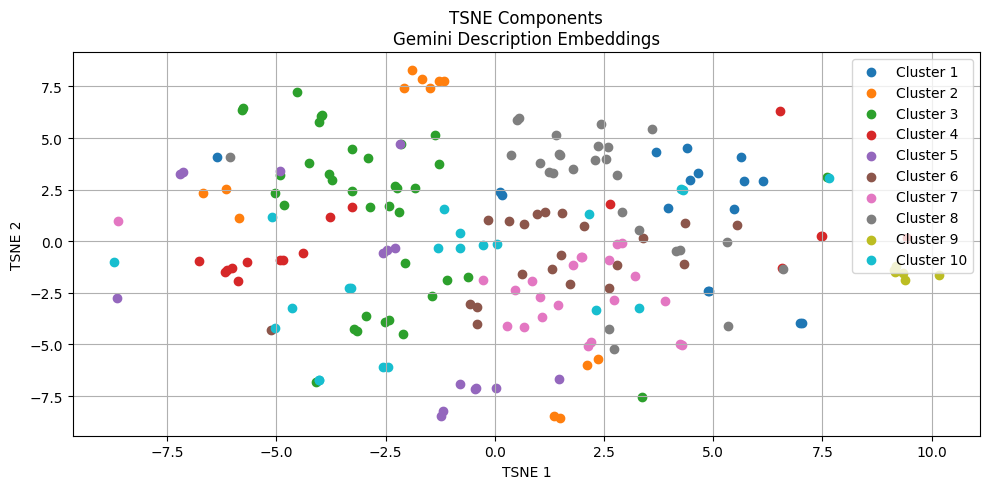

In [170]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=300)
reduced_embeddings = tsne.fit_transform(embeddings)

gemini_kmeans_cluster_reduced_embeddings = [list() for i in range(k)]
for e, label in zip(reduced_embeddings, gemini_kmeans_cluster_labels):
    gemini_kmeans_cluster_reduced_embeddings[label].append(e)

for i, l in enumerate(gemini_kmeans_cluster_reduced_embeddings):
    gemini_kmeans_cluster_reduced_embeddings[i] = np.array(l)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
for i, e in enumerate(gemini_kmeans_cluster_reduced_embeddings, start=1):
    s = ax.scatter(e[:,0], e[:,1], label=f'Cluster {i}')


ax.set_title('TSNE Components\nGemini Description Embeddings')
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.legend()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

## Scale time series

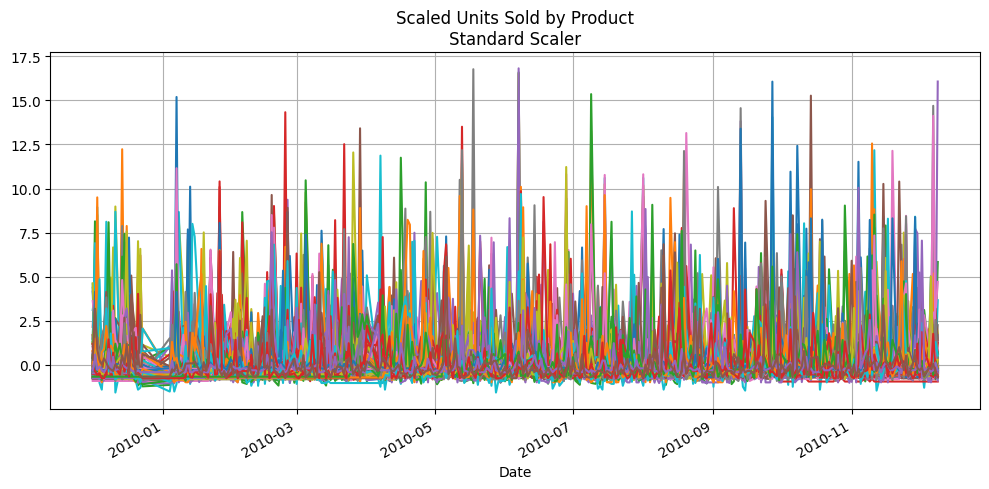

In [316]:
scaler = StandardScaler()
scaled = scaler.fit_transform(pivoted_df)

scaled_df = pd.DataFrame(data=scaled, columns=pivoted_df.columns, index=pivoted_df.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

scaled_df.plot(ax=ax)

ax.set_title('Scaled Units Sold by Product\nStandard Scaler')
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.legend().remove()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

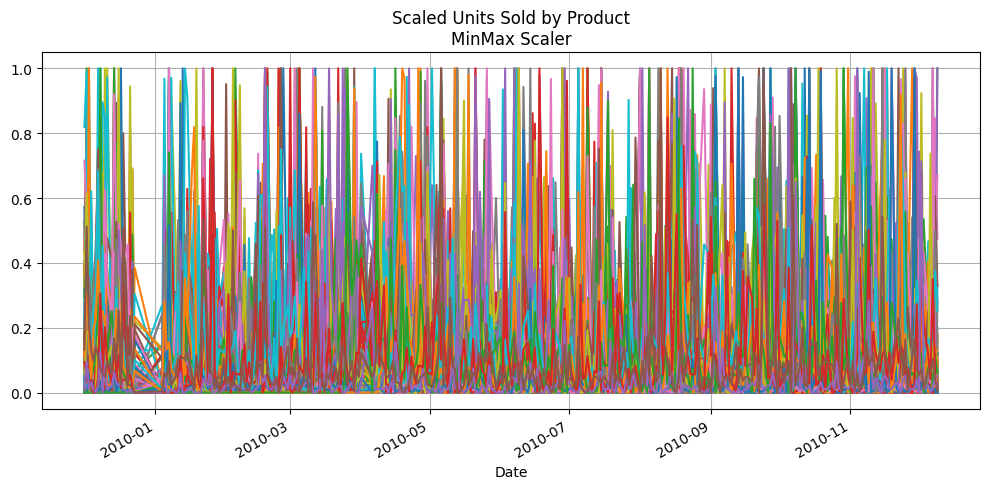

In [317]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(pivoted_df)

scaled_df = pd.DataFrame(data=scaled, columns=pivoted_df.columns, index=pivoted_df.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

scaled_df.plot(ax=ax)

ax.set_title('Scaled Units Sold by Product\nMinMax Scaler')
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.legend().remove()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

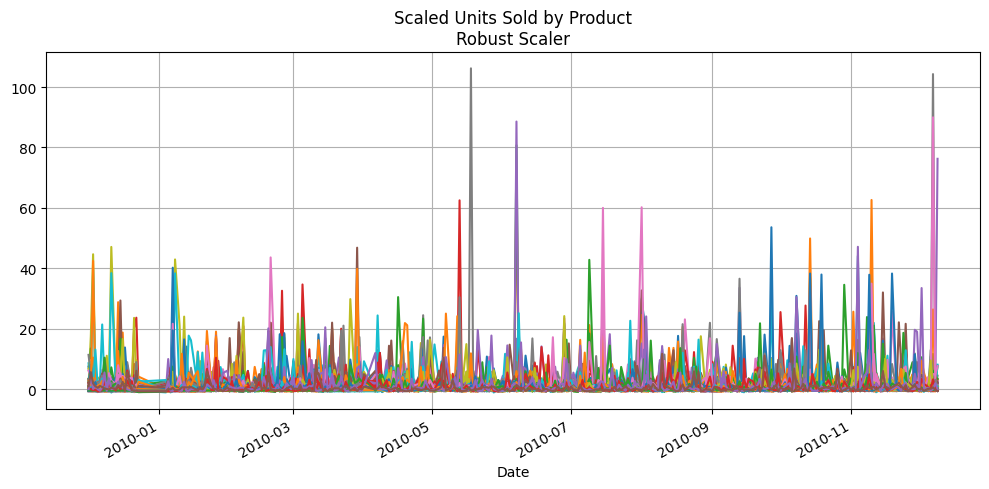

In [318]:
scaler = RobustScaler()
scaled = scaler.fit_transform(pivoted_df)

scaled_df = pd.DataFrame(data=scaled, columns=pivoted_df.columns, index=pivoted_df.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

scaled_df.plot(ax=ax)

ax.set_title('Scaled Units Sold by Product\nRobust Scaler')
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.legend().remove()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

## KMedoids + DTW

In [322]:
scaler = StandardScaler()
scaled = scaler.fit_transform(pivoted_df)

shape = scaled.shape
scaled = scaled.reshape((shape[0], shape[1], 1))

k_values = list(range(1, 15))
inertias = list()
for k in tqdm(k_values):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, n_init=1)
    kmeans.fit(scaled)
    inertias.append(kmeans.inertia_)

100%|███████████████████████████████████████████| 14/14 [07:07<00:00, 30.56s/it]


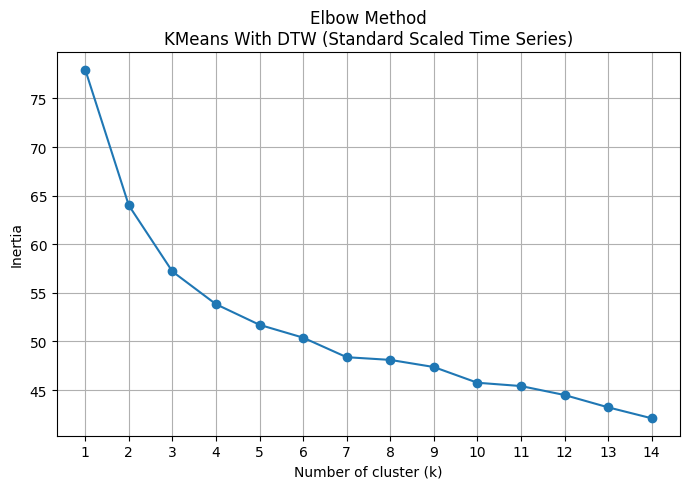

In [323]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(k_values, inertias, marker='o')

ax.set_title('Elbow Method\nKMeans With DTW (Standard Scaled Time Series)')
ax.set_xlabel('Number of cluster (k)')
ax.set_ylabel('Inertia')
ax.grid(True, which='both')

ax.set_xticks(np.arange(min(k_values), max(k_values) + 1, 1))

plt.tight_layout()
plt.show()

In [325]:
k = 4
kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, n_init=3)
labels = kmeans.fit_predict(scaled)

In [326]:
kmeans_clusters = [list() for label in range(k)]
for product, label in zip(product_descriptions, labels):
    kmeans_clusters[label].append(product)
kmeans_clusters

[['12 pencils tall tube woodland',
  'bag 500g swirly marbles',
  'door mat 3 smiley cats',
  'grand chocolatecandle',
  'hot baths metal sign',
  'love building block word',
  'lunch bag woodland',
  'lunchbag suki design',
  'memo board retrospot design',
  'pack of 6 birdy gift tags',
  'paper bunting retro spots',
  'paper chain kit retro spot',
  'red spotty charlotte bag',
  'regency cakestand 3 tier',
  'set of 3 heart cookie cutters',
  'set of 36 paisley flower doilies',
  'set of 36 teatime paper doilies',
  'victorian sewing box large',
  'weekend bag vintage rose paisley',
  'zinc metal heart decoration'],
 ['12 pencils small tube red spotty',
  '3 stripey mice feltcraft',
  '72 sweetheart fairy cake cases',
  'airline bag vintage jet set red',
  'assorted colour bird ornament',
  'bathroom metal sign',
  'beware of the cat metal sign',
  'ceramic cake bowl hanging cakes',
  'door mat fancy font home sweet home',
  'door mat new england',
  'door mat spotty home sweet home'

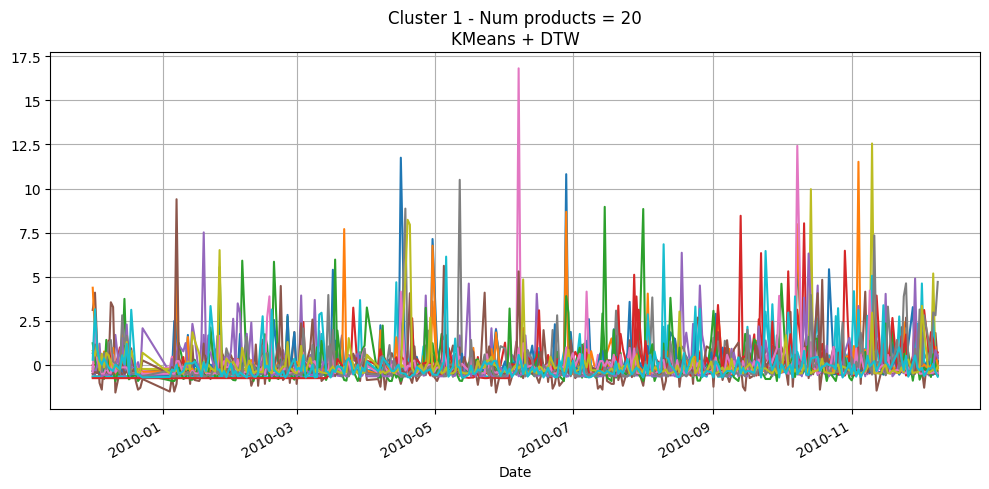

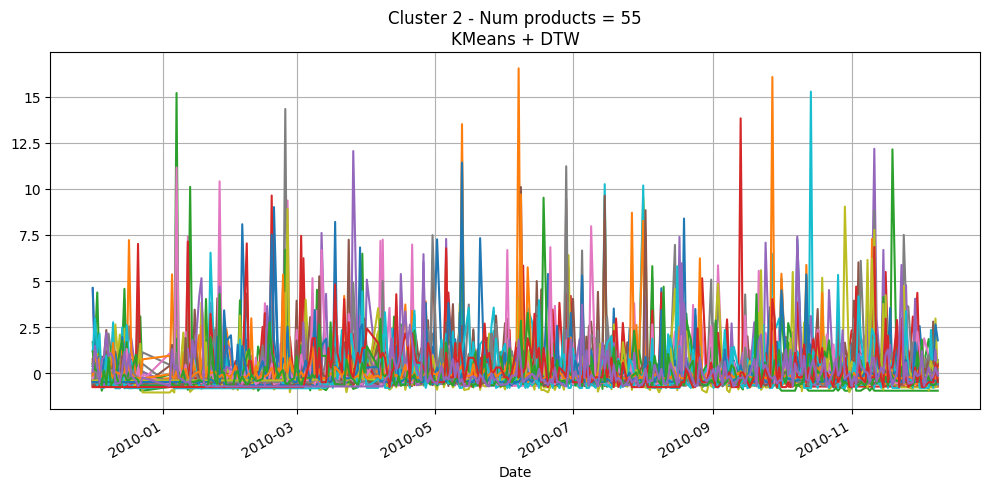

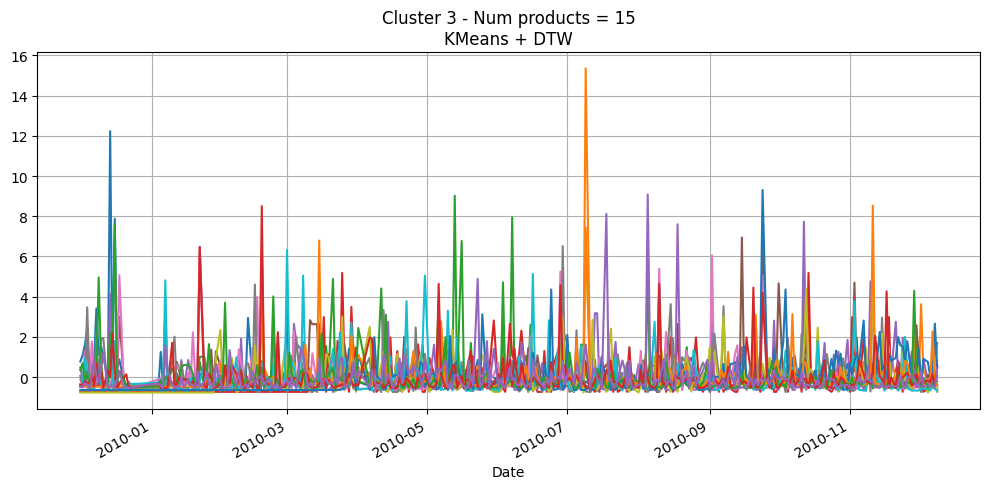

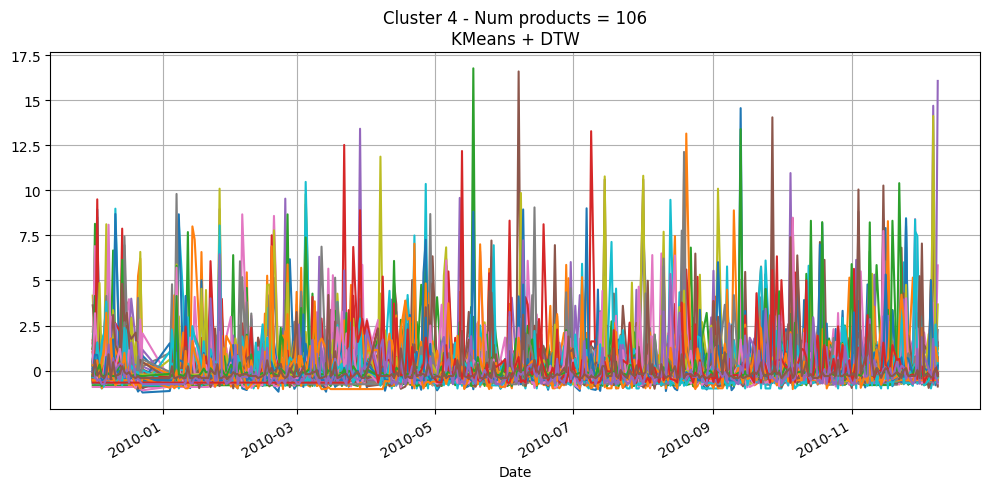

In [327]:
scaled_df = pd.DataFrame(
    data=StandardScaler().fit_transform(pivoted_df),
    columns=pivoted_df.columns,
    index=pivoted_df.index
).fillna(0)
for i, cluster in enumerate(kmeans_clusters, start=1):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    num_products = len(cluster)
    scaled_df[cluster].plot(ax=ax)
    ax.set_title(f'Cluster {i} - Num products = {num_products}\nKMeans + DTW')
    ax.set_xlabel('Date')
    ax.set_ylabel('')
    ax.grid(True, which='both')
    make_axes_human_readable(ax)
    ax.legend().remove()
    plt.tight_layout()
    plt.show()

## KShape

In [331]:
scaler = StandardScaler()
scaled = scaler.fit_transform(pivoted_df)

k_values = list(range(1, 23))
inertias = list()
for k in tqdm(k_values):
    ks = KShape(n_clusters=k, random_state=42, n_init=3)
    ks.fit(scaled)
    inertias.append(ks.inertia_)

100%|███████████████████████████████████████████| 22/22 [02:25<00:00,  6.62s/it]


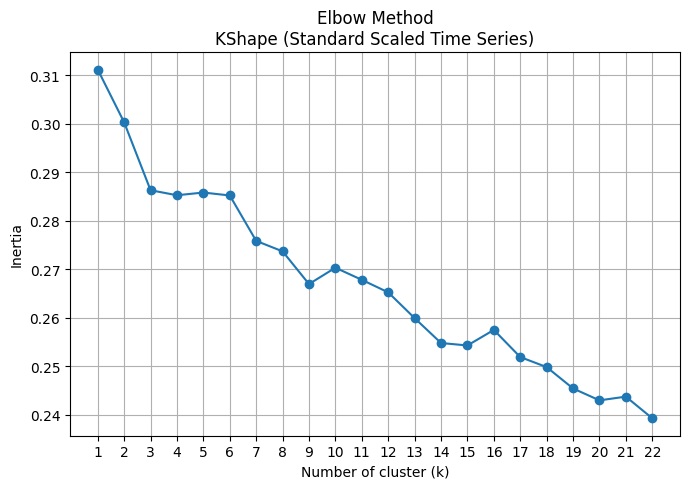

In [332]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(k_values, inertias, marker='o')

ax.set_title('Elbow Method\nKShape (Standard Scaled Time Series)')
ax.set_xlabel('Number of cluster (k)')
ax.set_ylabel('Inertia')
ax.grid(True, which='both')

ax.set_xticks(np.arange(min(k_values), max(k_values) + 1, 1))

plt.tight_layout()
plt.show()

In [337]:
k = 7
ks = KShape(n_clusters=k, random_state=42, n_init=3)
labels = ks.fit_predict(scaled)

In [338]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([  4,   4, 211,   8,  35,   8,  37]))

In [339]:
kshape_clusters = [list() for label in range(k)]
for product, label in zip(product_descriptions, labels):
    kshape_clusters[label].append(product)
kshape_clusters

[['colour glass tlight holder hanging', 'jumbo shopper vintage red paisley'],
 ['red spotty oven glove double'],
 ['12 pencils small tube red spotty',
  '3 stripey mice feltcraft',
  '6 ribbons rustic charm',
  '60 teatime fairy cake cases',
  '72 sweetheart fairy cake cases',
  'airline bag vintage jet set red',
  'assorted colour bird ornament',
  'baking set 9 piece retrospot',
  'baking set spaceboy design',
  'bathroom metal sign',
  'beware of the cat metal sign',
  'blue happy birthday bunting',
  'blue spotty cup',
  'box of 24 cocktail parasols',
  'ceramic cake bowl hanging cakes',
  'ceramic cake design spotted mug',
  'childs apron spaceboy design',
  'chocolate this way metal sign',
  'cream cupid hearts coat hanger',
  'cream heart card holder',
  'door mat 3 smiley cats',
  'door mat fairy cake',
  'door mat fancy font home sweet home',
  'door mat new england',
  'door mat red spot',
  'door mat spotty home sweet home',
  'door mat union flag',
  'edwardian parasol blac

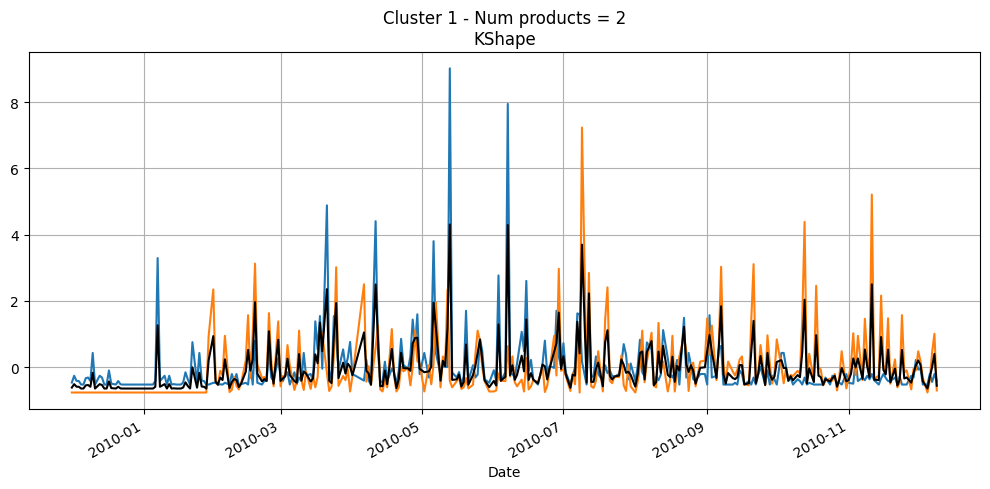

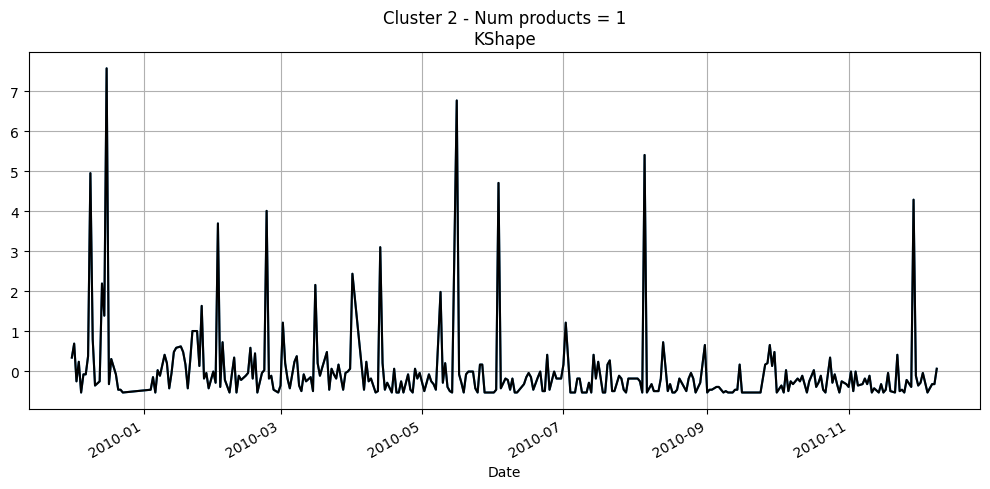

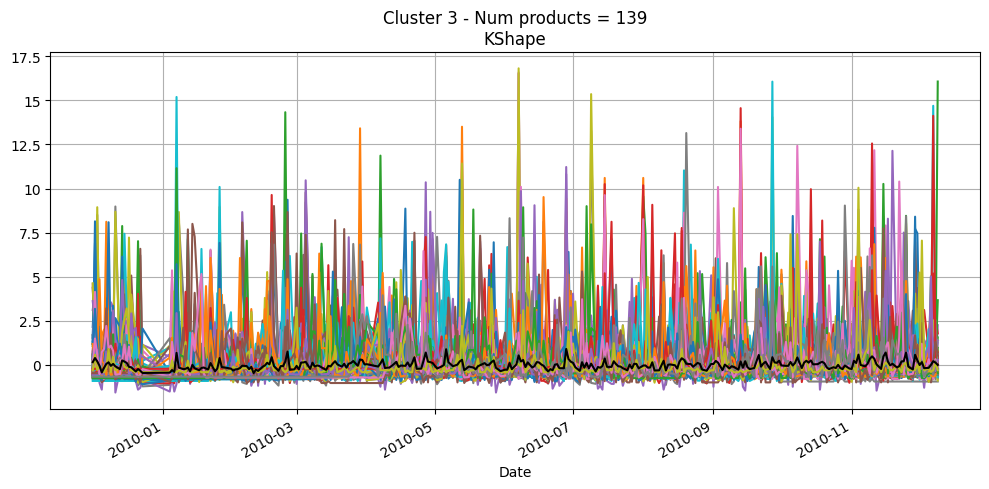

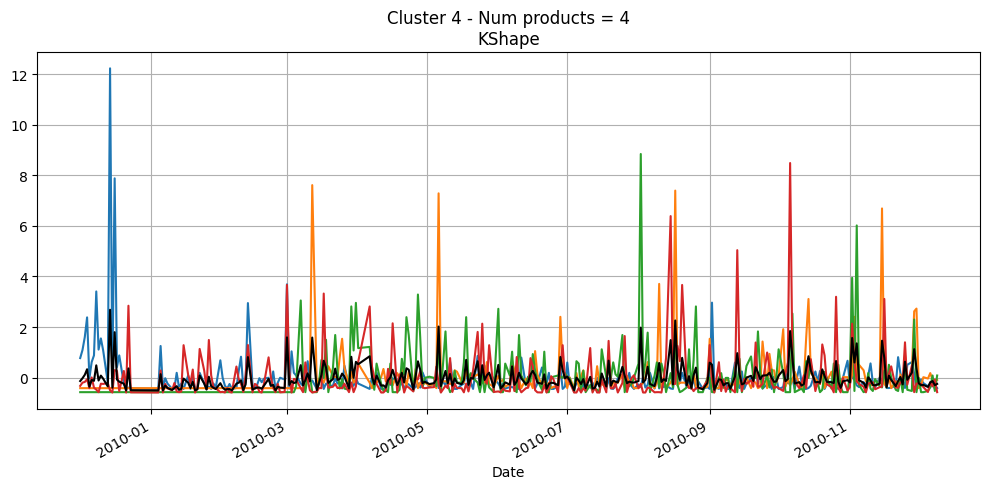

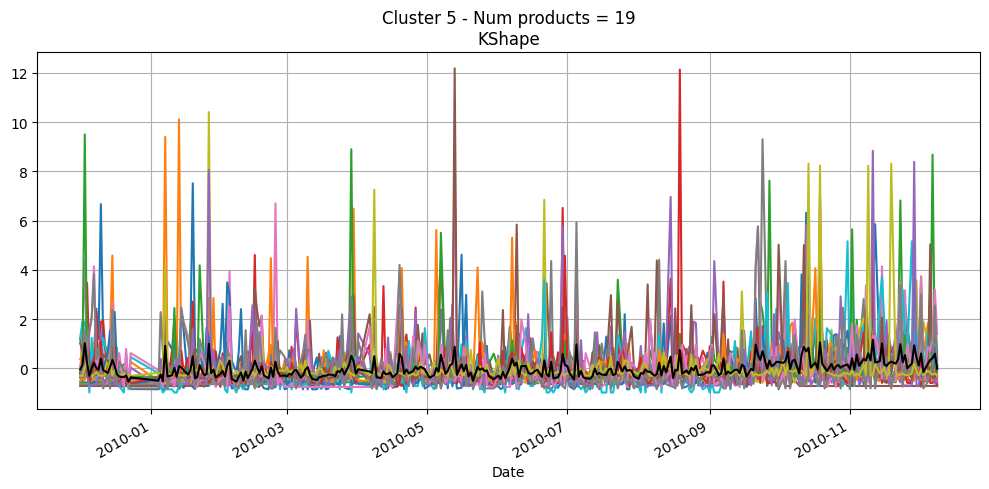

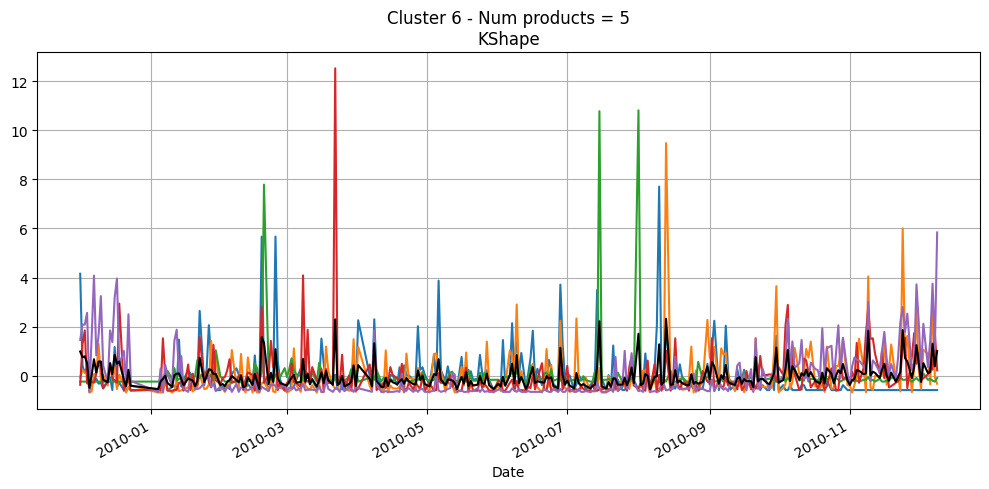

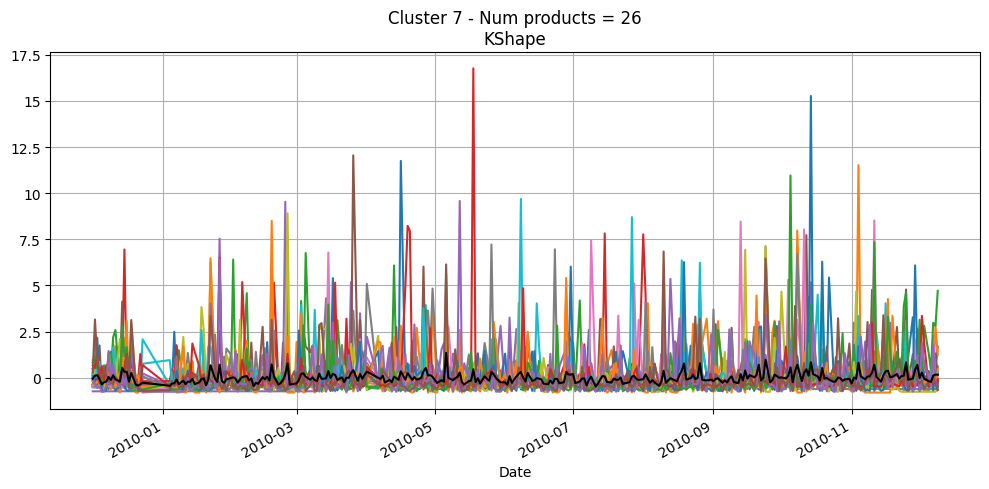

In [342]:
scaled_df = pd.DataFrame(
    data=StandardScaler().fit_transform(pivoted_df),
    columns=pivoted_df.columns,
    index=pivoted_df.index
).fillna(0)
for i, cluster in enumerate(kshape_clusters, start=1):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    num_products = len(cluster)
    scaled_df[cluster].plot(ax=ax)
    scaled_df[cluster].mean(axis=1).plot(ax=ax, color='black')
    ax.set_title(f'Cluster {i} - Num products = {num_products}\nKShape')
    ax.set_xlabel('Date')
    ax.set_ylabel('')
    ax.grid(True, which='both')
    make_axes_human_readable(ax)
    ax.legend().remove()
    plt.tight_layout()
    plt.show()

## Kshape with rolling average

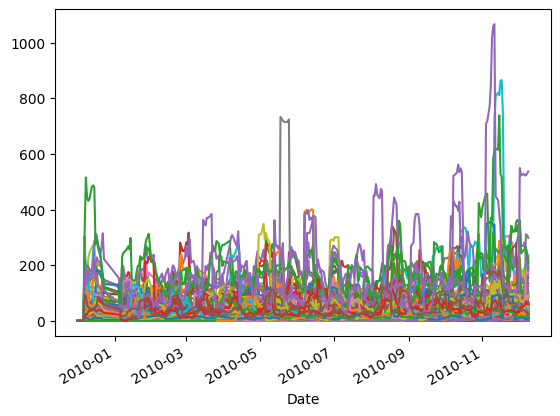

In [357]:
rolling_average = pivoted_df.rolling(7, axis=0).mean().fillna(0)
rolling_average.plot()
plt.legend().remove()

In [358]:
scaler = StandardScaler()
scaled = scaler.fit_transform(rolling_average)

k_values = list(range(1, 23))
inertias = list()
for k in tqdm(k_values):
    ks = KShape(n_clusters=k, random_state=42, n_init=3)
    ks.fit(scaled)
    inertias.append(ks.inertia_)

100%|███████████████████████████████████████████| 22/22 [02:41<00:00,  7.32s/it]


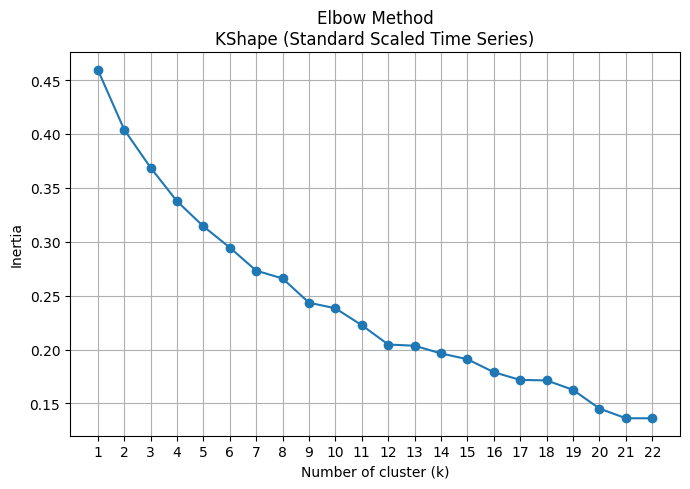

In [359]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(k_values, inertias, marker='o')

ax.set_title('Elbow Method\nKShape (Standard Scaled Time Series)')
ax.set_xlabel('Number of cluster (k)')
ax.set_ylabel('Inertia')
ax.grid(True, which='both')

ax.set_xticks(np.arange(min(k_values), max(k_values) + 1, 1))

plt.tight_layout()
plt.show()

In [360]:
k = 12
ks = KShape(n_clusters=k, random_state=42, n_init=3)
labels = ks.fit_predict(scaled)

In [361]:
kshape_clusters = [list() for label in range(k)]
for product, label in zip(product_descriptions, labels):
    kshape_clusters[label].append(product)
kshape_clusters

[['recycling bag retrospot',
  'red gingham rose jewellery box',
  'red spot ceramic drawer knob',
  'red spotty biscuit tin',
  'red spotty bowl',
  'red spotty charlotte bag',
  'red spotty oven glove double',
  'retro spot traditional teapot',
  'retro spots butter dish',
  'rex cashcarry jumbo shopper',
  'ribbon reel spots design',
  'round container set of 5 retrospot',
  'round snack boxes set 4 fruits',
  'round snack boxes set4 woodland',
  'scottie dog hot water bottle',
  'set 12 retro white chalk sticks',
  'strawberry lunchbox with cutlery',
  'swallows greeting card',
  'sweetheart ceramic trinket box',
  'tea bag plate red spotty',
  'tea party birthday card',
  'tea time tea towels',
  'toilet metal sign',
  'wooden box of dominoes',
  'wooden happy birthday garland'],
 ['12 pencils small tube red spotty',
  '12 pencils tall tube posy',
  '12 pencils tall tube woodland',
  '3 stripey mice feltcraft',
  '6 ribbons rustic charm',
  '60 teatime fairy cake cases',
  'lunchb

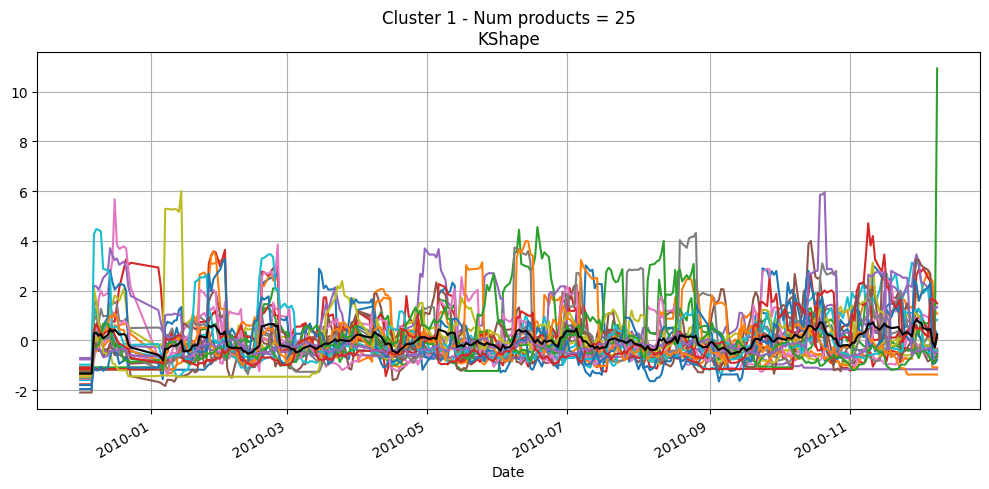

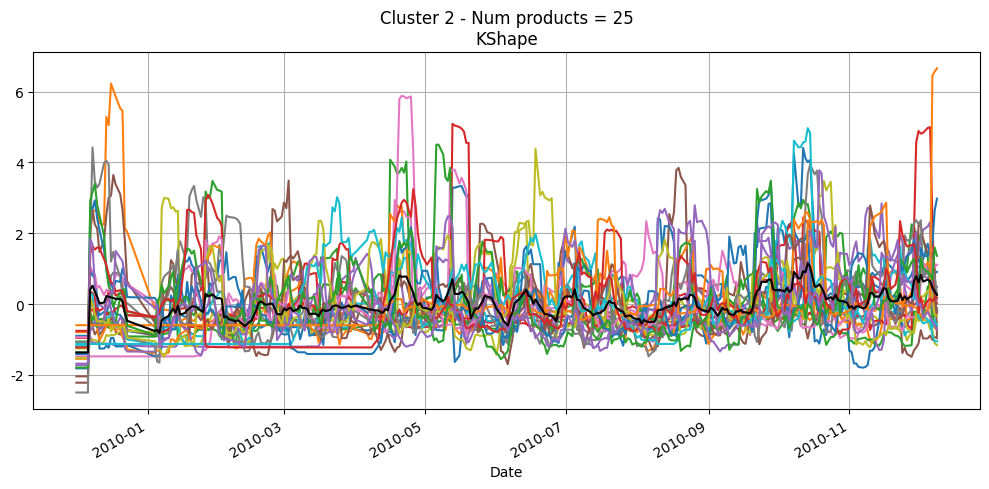

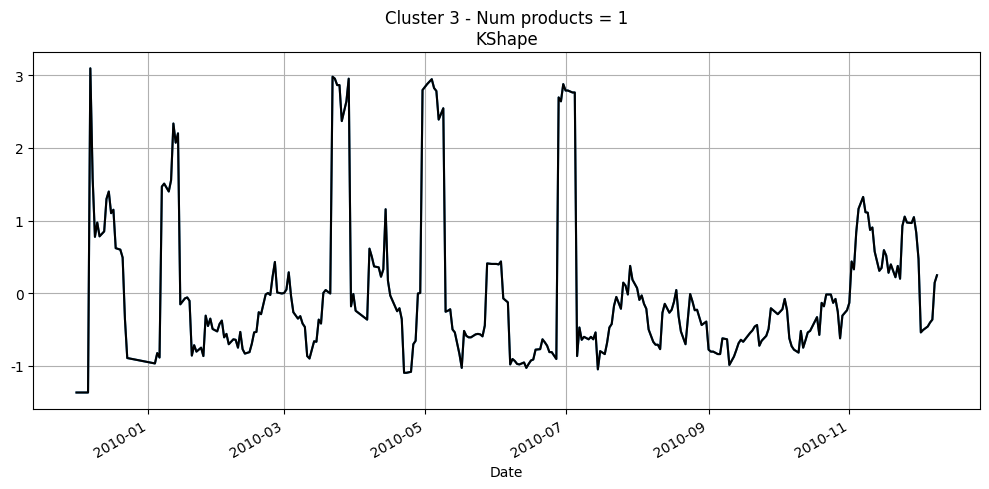

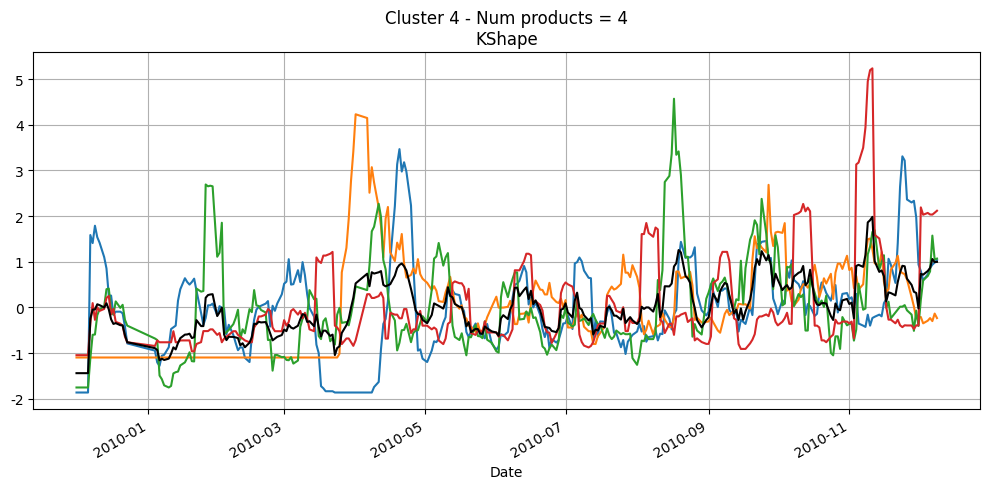

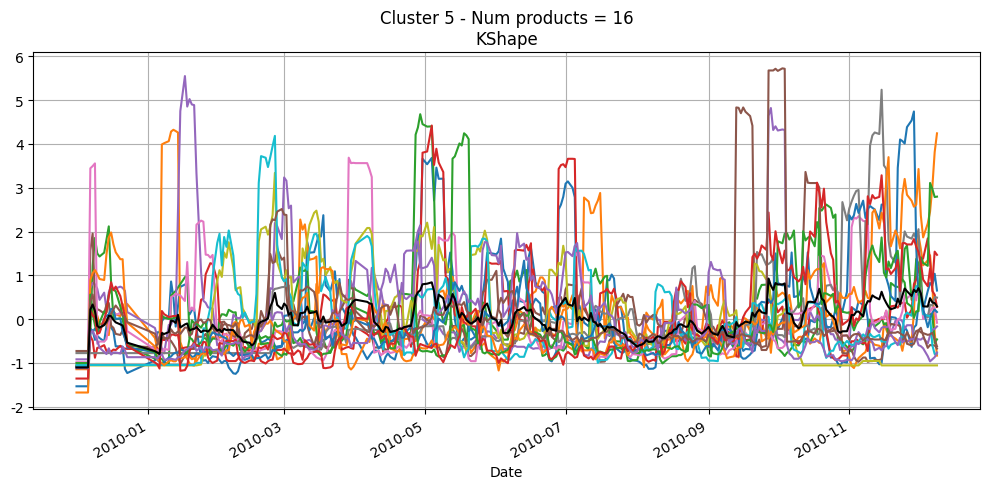

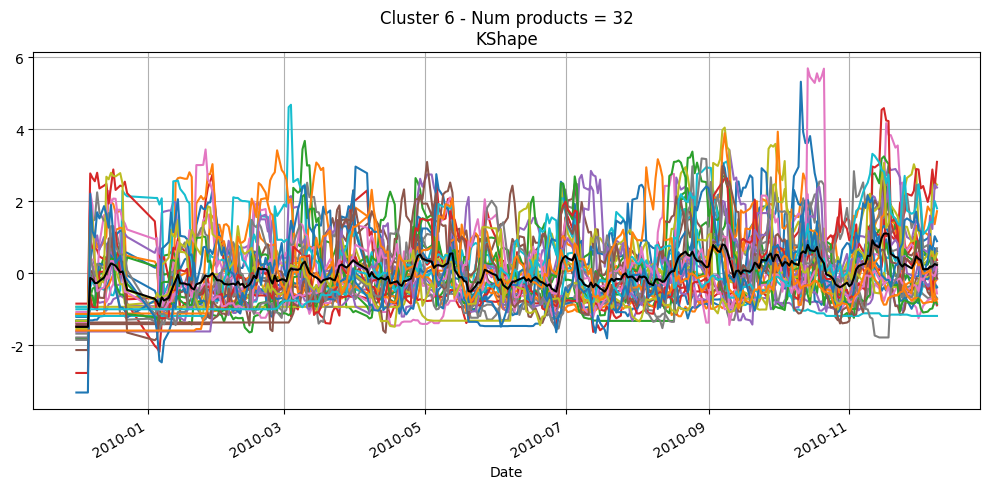

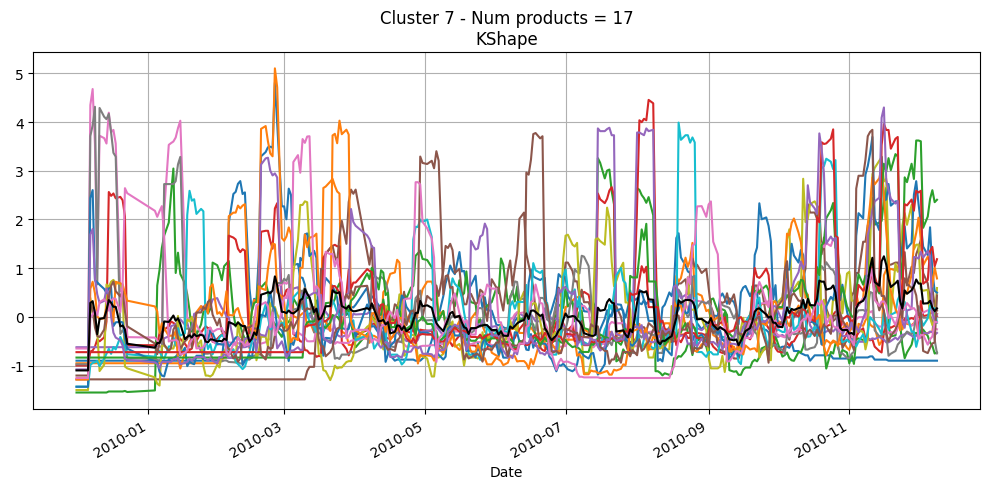

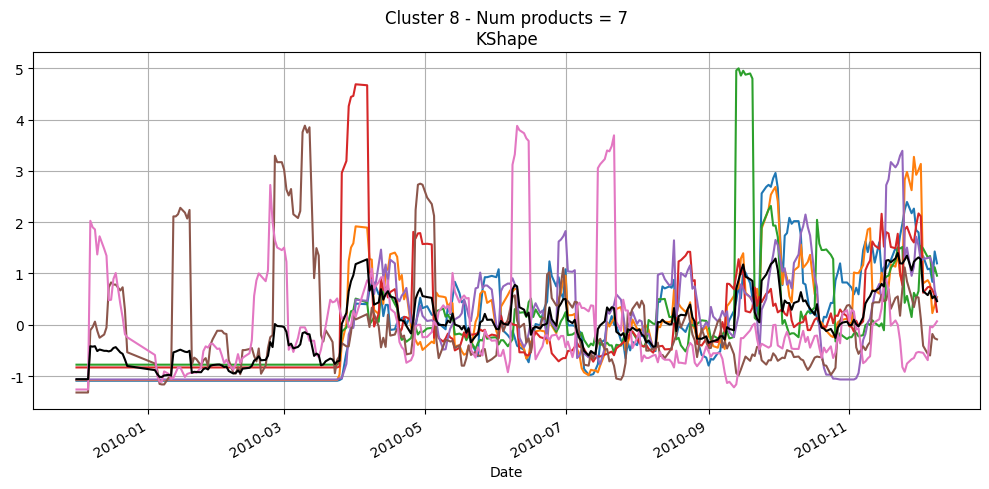

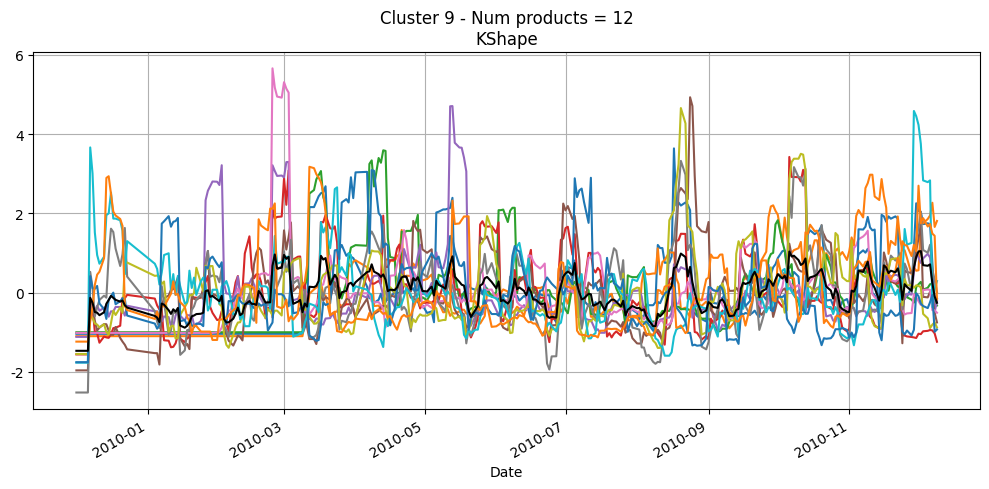

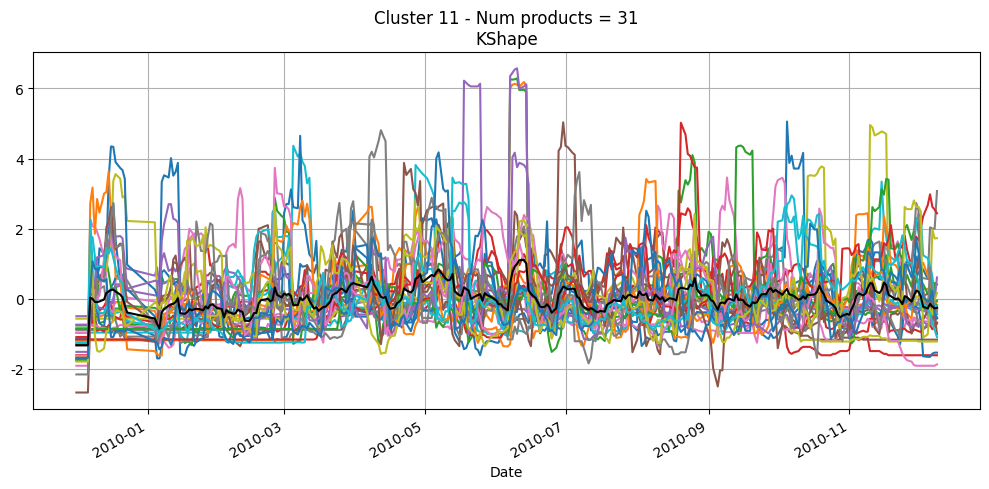

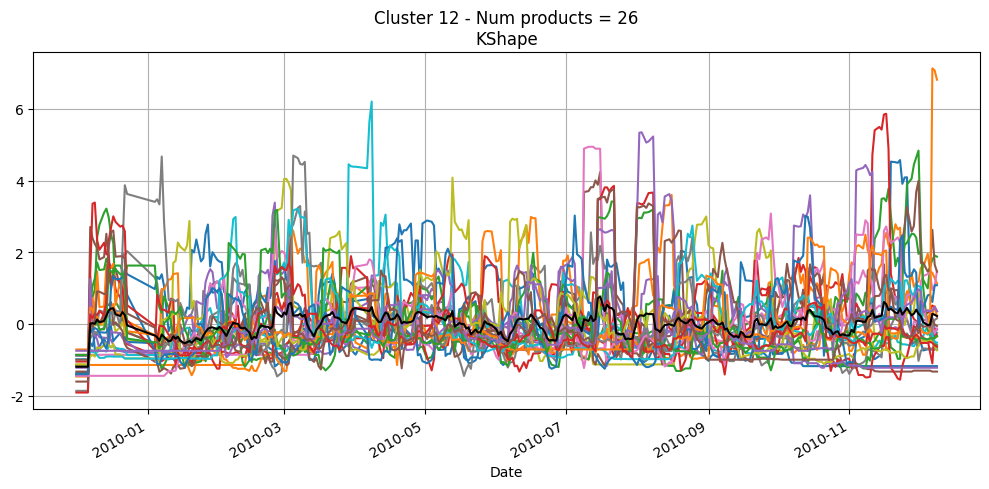

In [370]:
scaled_df = pd.DataFrame(
    data=StandardScaler().fit_transform(rolling_average),
    columns=rolling_average.columns,
    index=rolling_average.index
).fillna(0)
for i, cluster in enumerate(kshape_clusters, start=1):
    if not cluster:
        continue
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    num_products = len(cluster)
    scaled_df[cluster].plot(ax=ax)
    scaled_df[cluster].mean(axis=1).plot(ax=ax, color='black')
    ax.set_title(f'Cluster {i} - Num products = {num_products}\nKShape')
    ax.set_xlabel('Date')
    ax.set_ylabel('')
    ax.grid(True, which='both')
    make_axes_human_readable(ax)
    ax.legend().remove()
    plt.tight_layout()
    plt.show()

## DBSCAN + Feature Engineering

In [386]:
def analyze_time_series_with_significance(ts: pd.Series, lags: int = 40, alpha: float = 0.05):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))

    # Plot ACF
    plot_acf(ts, ax=axs[0], lags=lags, alpha=alpha, title='Autocorrelation (ACF)')

    # Plot PACF
    plot_pacf(ts, ax=axs[1], lags=lags, alpha=alpha, method='ywm', title='Partial Autocorrelation (PACF)')

    # Compute ACF and PACF with confidence intervals
    acf_vals, acf_confint = acf(ts, nlags=lags, alpha=alpha)
    pacf_vals, pacf_confint = pacf(ts, nlags=lags, alpha=alpha, method='ywm')

    def find_significant_lags(values, confint, name):
        significant = []
        for lag in range(1, len(values)):  # skip lag 0
            low, high = confint[lag]
            if low > 0 or high < 0:
                significant.append(lag)
        print(f"Significant lags in {name}: {significant}")

    find_significant_lags(acf_vals, acf_confint, "ACF")
    find_significant_lags(pacf_vals, pacf_confint, "PACF")

    # Fourier Transform Plot
    fft_vals = np.fft.fft(ts - np.mean(ts))
    fft_freq = np.fft.fftfreq(len(ts))
    amps = np.abs(fft_vals)

    axs[2].stem(fft_freq[:len(fft_freq)//2], amps[:len(amps)//2])
    axs[2].set_title("Fourier Transform (Amplitude Spectrum)")
    axs[2].set_xlabel("Frequency")
    axs[2].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

Significant lags in ACF: [3, 6, 9]
Significant lags in PACF: [3, 6]


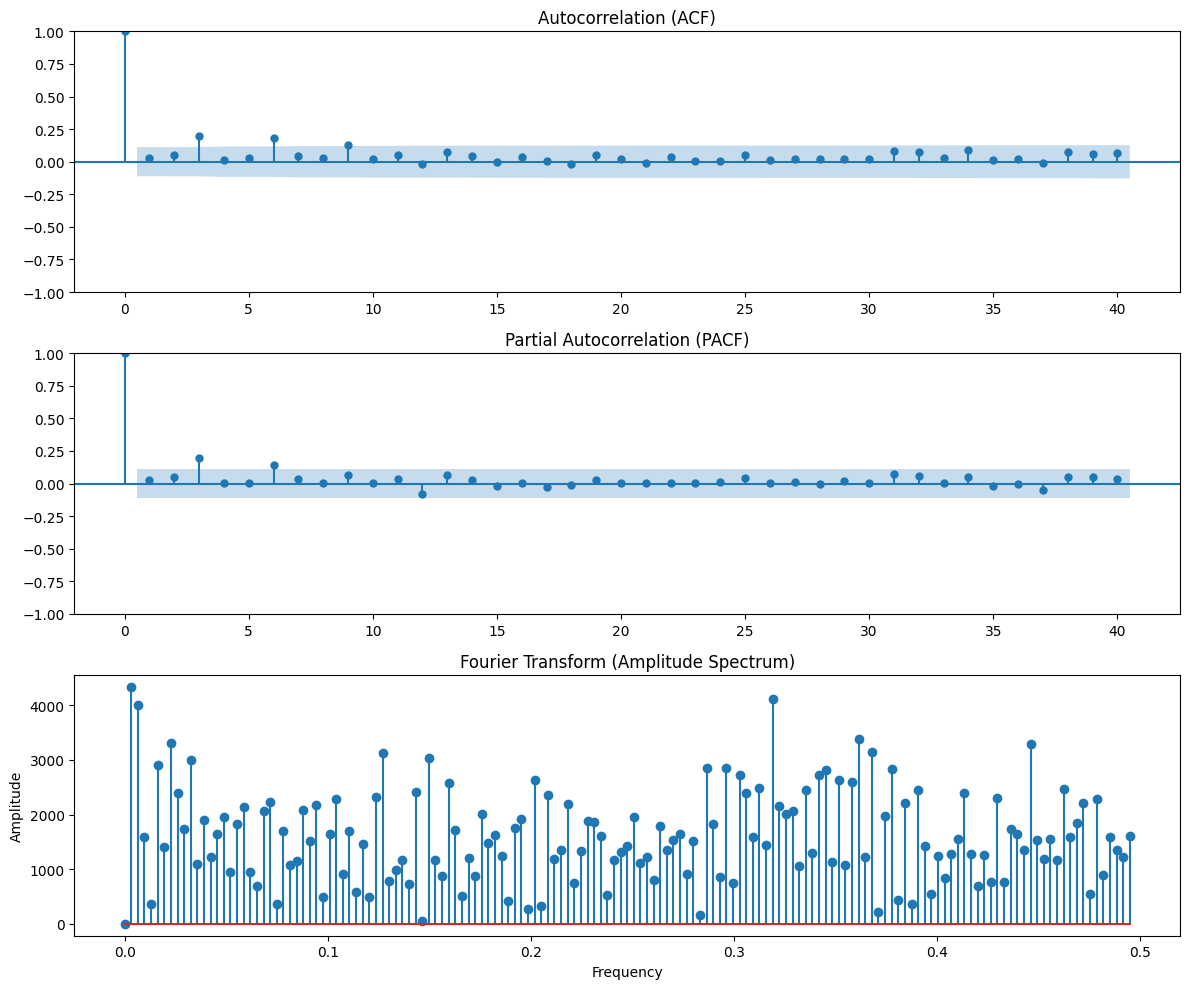

In [387]:
analyze_time_series_with_significance(pivoted_df['12 pencils small tube red spotty'])

In [454]:
def extract_time_series_features(ts: pd.Series, top_k: int = 3, acf_lags: int = 30) -> dict:
    # Ensure datetime index
    ts = ts.sort_index()
    ts = ts.asfreq(pd.infer_freq(ts.index) or 'D')  # infer frequency if not set
    ts_filled = ts.interpolate().fillna(method='bfill')

    features = {}

    # 1. ACF
    acf_vals = acf(ts_filled, nlags=acf_lags)
    top_acf_lags = np.argsort(np.abs(acf_vals[1:]))[::-1][:top_k] + 1
    for i, lag in enumerate(top_acf_lags):
        features[f'acf_lag_{i+1}'] = lag

    # 2. PACF
    pacf_vals = pacf(ts_filled, nlags=acf_lags, method='ywm')
    top_pacf_lags = np.argsort(np.abs(pacf_vals[1:]))[::-1][:top_k] + 1
    for i, lag in enumerate(top_pacf_lags):
        features[f'pacf_lag_{i+1}'] = lag

    # 3. FFT - top frequencies
    ts_detrended = ts_filled - ts_filled.mean()
    fft_vals = np.fft.fft(ts_detrended)
    fft_freqs = np.fft.fftfreq(len(fft_vals), d=1)
    amps = np.abs(fft_vals)
    pos_mask = fft_freqs > 0

    top_freqs = np.argsort(amps[pos_mask])[-top_k:]
    dominant_freqs = fft_freqs[pos_mask][top_freqs]
    dominant_amps = amps[pos_mask][top_freqs]

    for i, (f, a) in enumerate(zip(dominant_freqs, dominant_amps)):
        features[f'fft_period_{i+1}'] = 1 / f

    # 5. Peak month
    if ts_filled.index.inferred_freq in ['D', 'W']:
        monthly = ts_filled.resample('M').sum()
        peak_month = monthly.idxmax().month
        lowest_month = monthly.idxmin().month
        features['peak_month'] = peak_month
        features['lowest_month'] = lowest_month

    # 6. Trend (slope of linear regression)
    x = np.arange(len(ts_filled)).reshape(-1, 1)
    y = ts_filled.values.reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    features['trend_slope'] = reg.coef_[0][0]

    # 7. Seasonality strength
    try:
        decomposition = seasonal_decompose(ts_filled, model='additive', period=7)
        resid_std = decomposition.resid.std()
        seas_std = decomposition.seasonal.std()
        features['seasonality_strength'] = seas_std / resid_std if resid_std > 0 else 0
    except:
        features['seasonality_strength'] = 0

    return pd.Series(features)

acf_lag_1                 7.000000
acf_lag_2                 1.000000
acf_lag_3                 4.000000
pacf_lag_1                1.000000
pacf_lag_2                7.000000
pacf_lag_3                3.000000
fft_period_1             53.428571
fft_period_2            187.000000
fft_period_3            374.000000
peak_month               10.000000
lowest_month              4.000000
trend_slope               0.222710
seasonality_strength      0.122896
dtype: float64

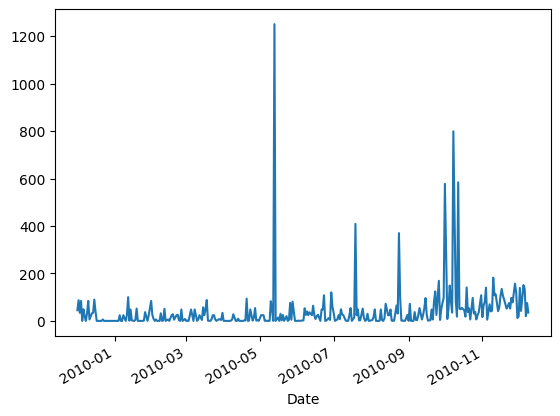

In [455]:
pivoted_df['12 pencils small tube red spotty'].plot()
extract_time_series_features(pivoted_df['12 pencils small tube red spotty'])

acf_lag_1                1.000000
acf_lag_2               17.000000
acf_lag_3               22.000000
pacf_lag_1               1.000000
pacf_lag_2               2.000000
pacf_lag_3              17.000000
fft_period_1             6.032258
fft_period_2            74.800000
fft_period_3             8.130435
peak_month              11.000000
lowest_month            12.000000
trend_slope              0.000905
seasonality_strength     0.176915
dtype: float64

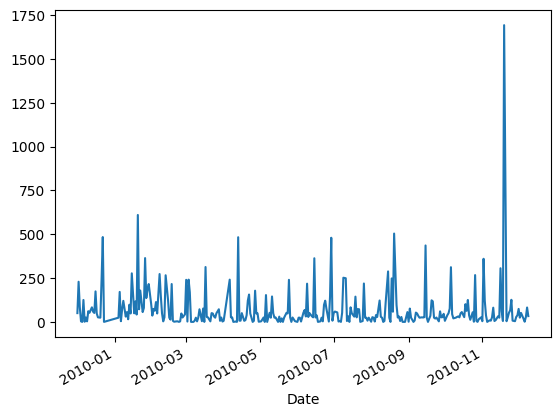

In [468]:
pivoted_df['72 sweetheart fairy cake cases'].plot()
extract_time_series_features(pivoted_df['72 sweetheart fairy cake cases'])

In [409]:
pivoted_df.sum(axis=0).sort_values(ascending=False)

FuzzedDescription
pack of 72 retro spot cake cases     60141.0
white hanging heart tlight holder    58793.0
world war 2 gliders asstd designs    55202.0
hanging heart zinc tlight holder     49214.0
assorted colour bird ornament        45356.0
                                      ...   
retro spot storage jar                1845.0
retro spots butter dish               1815.0
doorstop retrospot heart              1334.0
airline bag vintage jet set red       1056.0
white wood garden plant ladder         862.0
Length: 196, dtype: float64

acf_lag_1                1.000000
acf_lag_2                2.000000
acf_lag_3               25.000000
pacf_lag_1               1.000000
pacf_lag_2              27.000000
pacf_lag_3              24.000000
fft_period_1            26.714286
fft_period_2            17.000000
fft_period_3            62.333333
peak_month               4.000000
trend_slope              0.135642
seasonality_strength     0.231650
dtype: float64

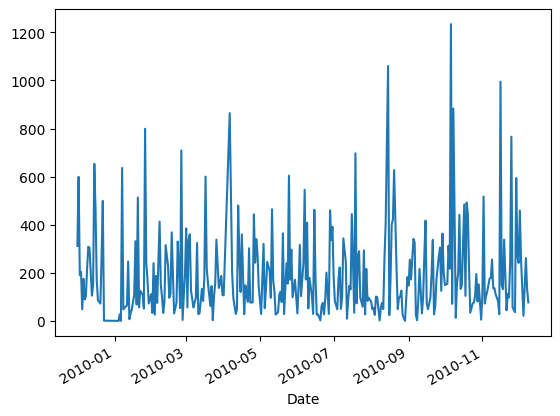

In [424]:
pivoted_df['pack of 72 retro spot cake cases'].plot()
extract_time_series_features(pivoted_df['pack of 72 retro spot cake cases'])

In [456]:
features_df = pivoted_df.apply(extract_time_series_features, axis=0).T
features_df

acf_lag_1  acf_lag_2  acf_lag_3  \
FuzzedDescription                                                    
12 pencils small tube red spotty         7.0        1.0        4.0   
12 pencils tall tube posy                2.0        6.0        4.0   
12 pencils tall tube woodland            1.0       30.0       14.0   
3 stripey mice feltcraft                11.0       10.0        1.0   
6 ribbons rustic charm                   1.0        5.0       10.0   
...                                      ...        ...        ...   
wooden picture frame white finish        1.0        2.0        3.0   
wooden school colouring set              1.0        7.0        6.0   
woodland charlotte bag                   1.0        4.0        3.0   
world war 2 gliders asstd designs       27.0       28.0        1.0   
zinc metal heart decoration              1.0       18.0        4.0   

                                   pacf_lag_1  pacf_lag_2  pacf_lag_3  \
FuzzedDescription                                                       
12 pencils small tube red spotty          1.0         7.0         3.0   
12 pencils tall tube posy                 2.0         6.0         1.0   
12 pencils tall tube woodland             1.0        30.0         2.0   
3 stripey mice feltcraft                 11.0        10.0        13.0   
6 ribbons rustic charm                    1.0         5.0         4.0   
...                                       ...         ...         ...   
wooden picture frame white finish         1.0         2.0         5.0   
wooden school colouring set               1.0         6.0         4.0   
woodland charlotte bag                    1.0         3.0         4.0   
world war 2 gliders asstd designs        27.0        28.0         1.0   
zinc metal heart decoration               1.0         4.0        18.0   

                                   fft_period_1  fft_period_2  fft_period_3  \
FuzzedDescription                                                             
12 pencils small tube red spotty      53.428571    187.000000    374.000000   
12 pencils tall tube posy             74.800000    374.000000     93.500000   
12 pencils tall tube woodland          6.233333      5.123288    187.000000   
3 stripey mice feltcraft               3.528302      3.702970    187.000000   
6 ribbons rustic charm                46.750000    374.000000    187.000000   
...                                         ...           ...           ...   
wooden picture frame white finish     31.166667    187.000000     41.555556   
wooden school colouring set           93.500000    374.000000    187.000000   
woodland charlotte bag                34.000000     22.000000      3.495327   
world war 2 gliders asstd designs     31.166667     17.000000      3.895833   
zinc metal heart decoration           11.687500      3.224138     15.583333   

                                   peak_month  lowest_month  trend_slope  \
FuzzedDescription                                                          
12 pencils small tube red spotty         10.0           4.0     0.222710   
12 pencils tall tube posy                12.0          12.0    -0.089184   
12 pencils tall tube woodland            10.0          12.0     0.093804   
3 stripey mice feltcraft                 10.0           1.0     0.038241   
6 ribbons rustic charm                   11.0           2.0     0.154386   
...                                       ...           ...          ...   
wooden picture frame white finish         4.0           2.0     0.039690   
wooden school colouring set               4.0          12.0     0.074524   
woodland charlotte bag                    8.0          12.0     0.063605   
world war 2 gliders asstd designs        11.0           1.0     0.555080   
zinc metal heart decoration               8.0          12.0     0.026780   

                                   seasonality_strength  
FuzzedDescription                                        
12 pencils small tube red spotty         

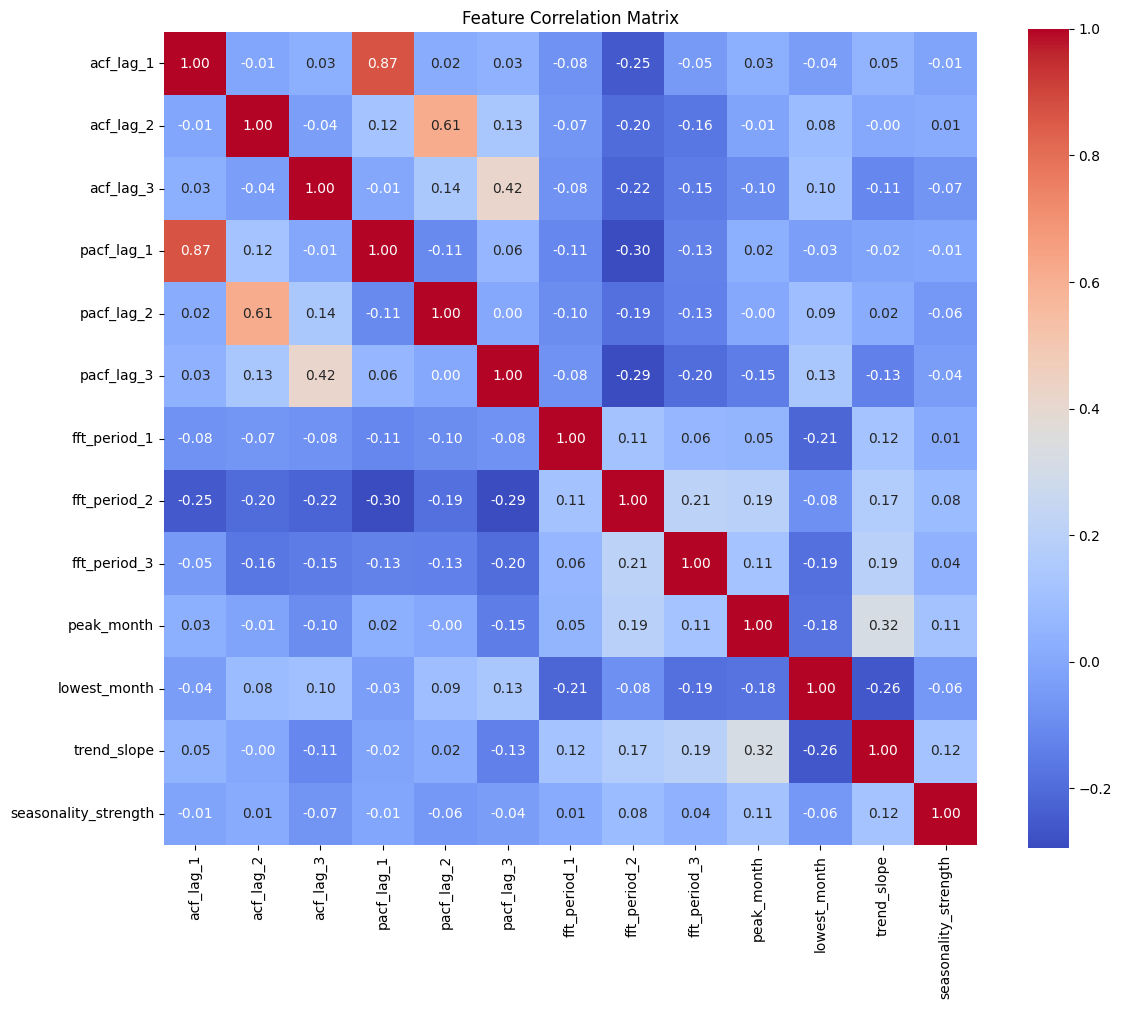

In [457]:
correlation_matrix = features_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

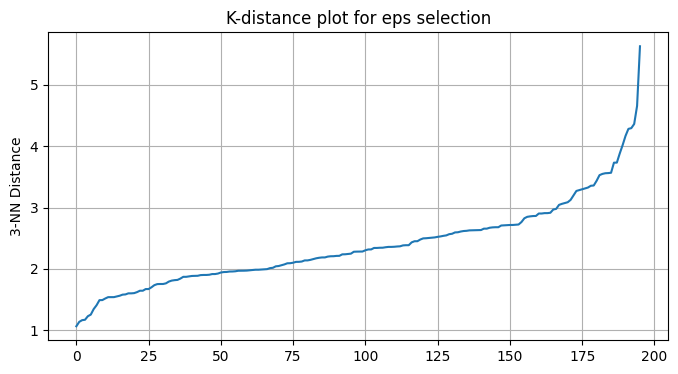

In [458]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Take the k-th nearest distance and sort
k_distances = np.sort(distances[:, 2])  # 4 = k-1 if n_neighbors=5

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel("3-NN Distance")
plt.title("K-distance plot for eps selection")
plt.grid()
plt.show()

In [459]:
dbscan = DBSCAN(eps=3.5, min_samples=3)  # these are hyperparameters to tune!
labels = dbscan.fit_predict(X_scaled)
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0])

In [462]:
dbscan_clusters = [list() for label in range(len(np.unique(labels)))]
for product, label in zip(product_descriptions, labels):
    dbscan_clusters[label].append(product)
dbscan_clusters

[['12 pencils small tube red spotty',
  '12 pencils tall tube posy',
  '12 pencils tall tube woodland',
  '3 stripey mice feltcraft',
  '6 ribbons rustic charm',
  '60 teatime fairy cake cases',
  '72 sweetheart fairy cake cases',
  'airline bag vintage jet set red',
  'antique silver tea glass etched',
  'baking set 9 piece retrospot',
  'baking set spaceboy design',
  'bathroom metal sign',
  'beware of the cat metal sign',
  'blue happy birthday bunting',
  'blue spotty cup',
  'box of 24 cocktail parasols',
  'ceramic cake bowl hanging cakes',
  'ceramic cake design spotted mug',
  'charlotte bag pinkwhite spots',
  'charlotte bag suki design',
  'childs apron spaceboy design',
  'chocolate this way metal sign',
  'colour glass tlight holder hanging',
  'cook with wine metal sign',
  'cream cupid hearts coat hanger',
  'cream heart card holder',
  'door mat 3 smiley cats',
  'door mat fairy cake',
  'door mat fancy font home sweet home',
  'door mat new england',
  'door mat red sp

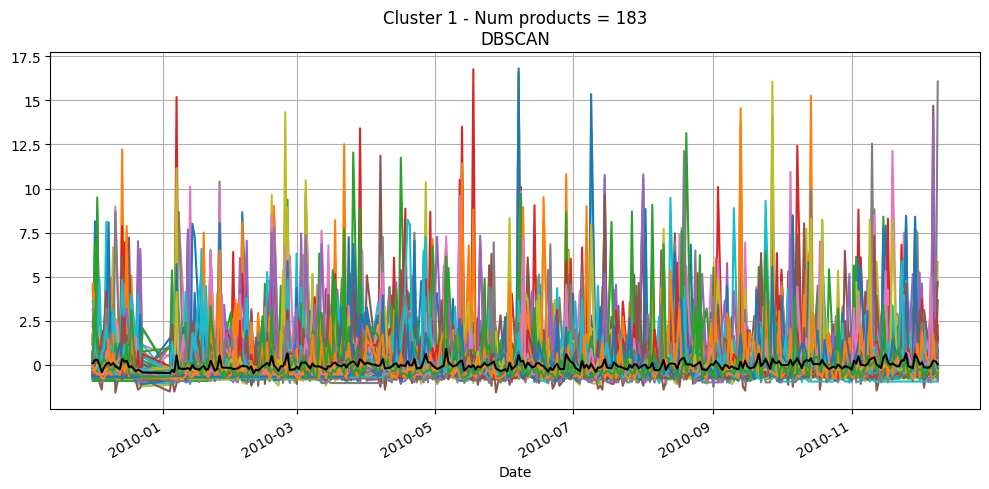

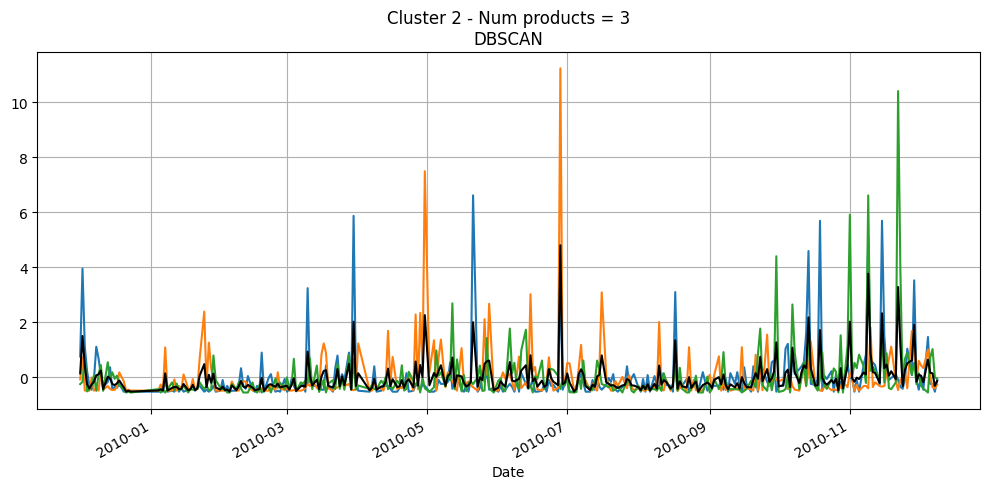

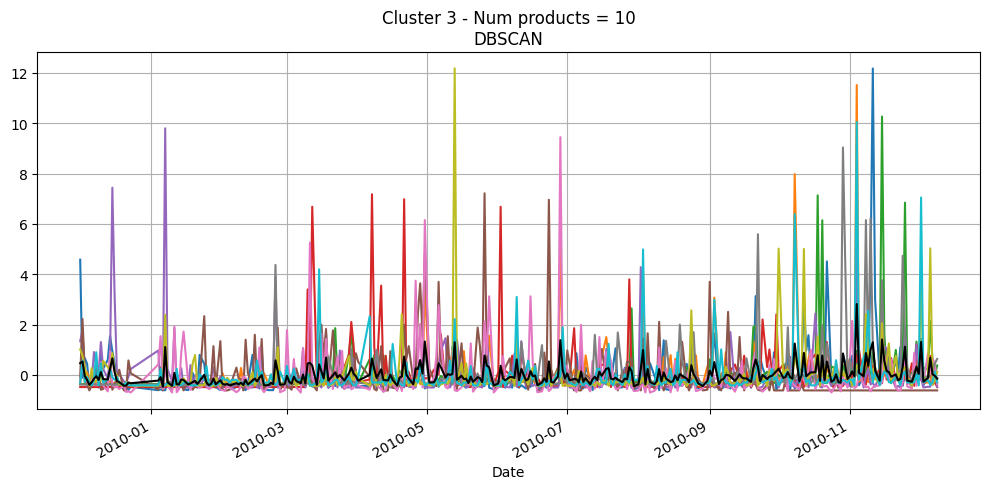

In [466]:
scaled_df = pd.DataFrame(
    data=StandardScaler().fit_transform(pivoted_df),
    columns=pivoted_df.columns,
    index=pivoted_df.index
).fillna(0)
for i, cluster in enumerate(dbscan_clusters, start=1):
    if not cluster:
        continue
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    num_products = len(cluster)
    scaled_df[cluster].plot(ax=ax)
    scaled_df[cluster].mean(axis=1).plot(ax=ax, color='black')
    ax.set_title(f'Cluster {i} - Num products = {num_products}\nDBSCAN')
    ax.set_xlabel('Date')
    ax.set_ylabel('')
    ax.grid(True, which='both')
    make_axes_human_readable(ax)
    ax.legend().remove()
    plt.tight_layout()
    plt.show()

## Combined approaches

In [554]:
file_path = '../dataset/gemini_product_descriptions/gemini_product_descriptions2.json'
with open(file_path, 'r') as f:
    gemini_descriptions = json.load(f)

In [560]:
gemini_descriptions_list = [
    (product_description, sales_description)
    for product_description, sales_description in gemini_descriptions.items()
]

product_descriptions, sales_descriptions = zip(*gemini_descriptions_list)
product_descriptions = list(product_descriptions)
sales_descriptions = list(sales_descriptions)

model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# Normalizing makes the maximizing the cosine similarity the
# same as minimizing the Euclidean distance.
embeddings = model.encode(sales_descriptions, normalize_embeddings=True)

k = 10
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(embeddings)

gemini_description_labels = pd.Series(kmeans.labels_, index=product_descriptions)
gemini_description_labels

12 pencils small tube red spotty     9
12 pencils tall tube posy            9
12 pencils tall tube woodland        2
3 stripey mice feltcraft             2
6 ribbons rustic charm               2
                                    ..
wooden picture frame white finish    2
wooden school colouring set          2
woodland charlotte bag               6
world war 2 gliders asstd designs    3
zinc metal heart decoration          3
Length: 196, dtype: int32

In [573]:
scaler = StandardScaler()
scaled = scaler.fit_transform(pivoted_df).T

k = 4
kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, n_init=3)
labels = kmeans.fit_predict(scaled)

kmeans_dtw_labels = pd.Series(labels, index=pivoted_df.columns)
kmeans_dtw_labels

FuzzedDescription
12 pencils small tube red spotty     0
12 pencils tall tube posy            1
12 pencils tall tube woodland        1
3 stripey mice feltcraft             1
6 ribbons rustic charm               3
                                    ..
wooden picture frame white finish    0
wooden school colouring set          3
woodland charlotte bag               3
world war 2 gliders asstd designs    2
zinc metal heart decoration          3
Length: 196, dtype: int64

In [585]:
gemini_description_labels.name = 'gemini_description'
kmeans_dtw_labels.name = 'kmeans_dtw'
combined_labels_df = pd.concat([gemini_description_labels, kmeans_dtw_labels], axis=1)
combined_labels_df.index.name = 'product_description'
combined_labels_df = combined_labels_df.reset_index()
combined_labels_df

product_description  gemini_description  kmeans_dtw
0     12 pencils small tube red spotty                   9           0
1            12 pencils tall tube posy                   9           1
2        12 pencils tall tube woodland                   2           1
3             3 stripey mice feltcraft                   2           1
4               6 ribbons rustic charm                   2           3
..                                 ...                 ...         ...
191  wooden picture frame white finish                   2           0
192        wooden school colouring set                   2           3
193             woodland charlotte bag                   6           3
194  world war 2 gliders asstd designs                   3           2
195        zinc metal heart decoration                   3           3

[196 rows x 3 columns]

In [589]:
combined_labels_df.groupby(['gemini_description', 'kmeans_dtw']).nunique().reset_index().sort_values(by='product_description', ascending=False)

gemini_description  kmeans_dtw  product_description
10                   2           3                   15
29                   7           3                   13
33                   9           0                   10
25                   6           3                   10
9                    2           2                   10
21                   5           3                    9
7                    2           0                    8
11                   3           0                    8
36                   9           3                    7
16                   4           1                    6
27                   7           1                    6
26                   7           0                    6
22                   6           0                    6
17                   4           3                    6
0                    0           0                    6
2                    0           3                    6
5                    1           2                    5
14                   3           3                    5
20                   5           2                    5
23                   6           1                    5
1                    0           2                    4
19                   5           1                    4
8                    2           1                    4
3                    1           0                    4
34                   9           1                    3
32                   8           3                    3
15                   4           0                    3
6                    1           3                    3
18                   5           0                    3
28                   7           2                    2
31                   8           1                    2
12                   3           1                    2
13                   3           2                    2
35                   9           2                    2
4                    1           1                    1
30                   8           0                    1
24                   6           2                    1

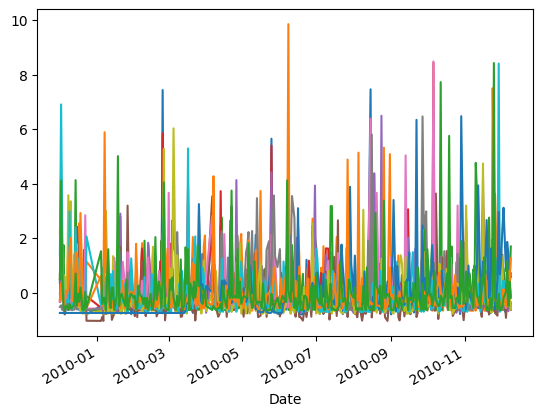

In [599]:
descriptions = combined_labels_df.query('gemini_description == 7 and kmeans_dtw == 3')['product_description']
scaled_df[descriptions].plot()
plt.legend().remove()